In [1]:
import numpy as np
import matplotlib.pyplot as plt

from environment import State, Environment
from environment import DEFAULT_START_ST, DEFAULT_GOAL_ST, DEFAULT_CONFIG, SIMPLE_CONFIG

In [2]:
X_init = State(*DEFAULT_START_ST)
X_goal = State(*DEFAULT_GOAL_ST)

In [3]:
env = Environment.from_config(X_init, SIMPLE_CONFIG)

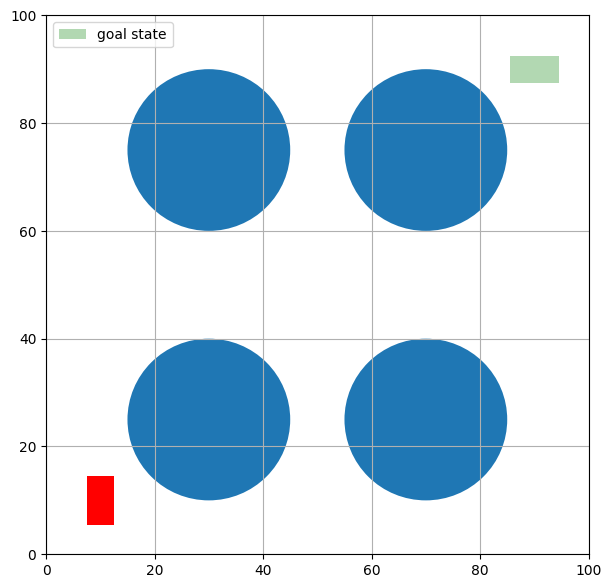

In [4]:
env.render(goal_state=State(*DEFAULT_GOAL_ST))

In [5]:

        '''
            if environment.check_collision(State(x_new)):
                X_near = Near(V, x_new, r_comp(V, gamma, nu, d))
                V.append(x_new)
                E.append([x, x_new])
                E.append([x_new, x])
                
                for x in X_near:
                    if environment.check_collision(State(x)) and X_near not None:
                        E.append([x, x_new])
                        E.append([x_new, x])
                X_near = None
                
        return returning(X_init, X_goal, E, samples)
        '''

'\n    if environment.check_collision(State(x_new)):\n        X_near = Near(V, x_new, r_comp(V, gamma, nu, d))\n        V.append(x_new)\n        E.append([x, x_new])\n        E.append([x_new, x])\n        \n        for x in X_near:\n            if environment.check_collision(State(x)) and X_near not None:\n                E.append([x, x_new])\n                E.append([x_new, x])\n        X_near = None\n        \nreturn returning(X_init, X_goal, E, samples)\n'

In [51]:
def sample(N):
    a = np.random.uniform(low=0, high=100, size=(N, 2))
    b = np.random.uniform(low=-180, high=180, size=(N, 1))
    #print(a, b)
    c = np.hstack((a, b))
    return c

In [5]:
# V = [([0, 0], 90), ([30, 30], 30)]

In [34]:
class RRGStar:
    def __init__(self, N, env):
        self.N = N
        self.environment = env
        self.nu = 0.01
        self.r = 1
        
        
    def distance(self, state1: State, state2: State) -> float:
        """Returns distance between two states"""
        state_dif = state1._center_coors - state2._center_coors
        angle_dif = state1._angle - state2._angle
        return np.linalg.norm(state_dif) + \
            np.abs(angle_dif)
    
    
    def Nearest(self,
                V,
                x,
               ):
        
        m = None
        min_v = 10000
        for v in V:
            curr_min = self.distance(State(v[0], v[1]), State(x[0], x[1]))
            if curr_min < min_v:
                min_v = curr_min
                m = v

        return m
    
    
    def Steer(self,
             x_nearest,
             x_rand):
        
        max_step = 5
        a = []
        
        # coordinates:
        
        for i in range(2):
            if x_rand[0][i] - x_nearest[0][i] > 5:
                a.append(5)
            elif x_rand[0][i] - x_nearest[0][i] < -5:
                a.append(-5)
            else:
                a.append(x_rand[0][i] - x_nearest[0][i])
        
        # angles:
        
        lst = np.linspace(start=0, stop=180, num=18)
        if self.environment.check_collision(State(x_nearest[0] + np.array(a), x_nearest[1])):
            for j in lst:
                if not self.environment.check_collision(State(x_nearest[0] + np.array(a), j)):
                    return (x_nearest[0] + np.array(a), j)
            return -1
        
        else:
            return (x_nearest[0] + np.array(a), x_nearest[1])    
    
    
    def Near(self, V, x):
        s = []
        for v in V:
            if ((x[0][0] - v[0][0]) ** 2 + (x[0][1] - v[0][1]) ** 2) <= self.r ** 2:
                s.append(v)
        return s        
    

    def generate_lin_space(self, start_state, end_state):
        
        n = int((end_state[0] - start_state[0]) / 5)

        m = int((end_state[1] - start_state[1]) / 5)
        
        k = max(n, m)
        
        if k == 0:
            k = 1
            
        dist_step = (end_state - start_state) / k
        res = [start_state]
        if max(n, m) - min(n, m) == 0:
            r = m
        else:
            r = max(n, m) - min(n, m)
            
        for j in range(r):
            a, b = 0, 0
            if end_state[0] - res[j][0] >= 5 and (res[j][0] + 5) <= end_state[0]:
                a = 5
            elif end_state[0] - res[j][0] < 5:
                a = end_state[0] - res[j][0]
            elif end_state[1] - res[j][1] >= 5 and (res[j][1] + 5) <= end_state[1]:
                b = 5
            else:
                b = end_state[1] - res[j][1]
            
            res.append(res[-1] + [a, b])
        
        if r < n:
            for j in range(n - r):
                a, b = 0, 0
                if end_state[0] - res[j][0] >= 5 and (res[j][0] + 5) <= end_state[0]:
                    a = 5
                elif end_state[0] - res[j][0] < 5:
                    a = end_state[0] - res[j][0]
        
                res.append(res[-1] + [a, b])
            
        elif r < m:
            for j in range(m - r):
                a, b = 0, 0
                if end_state[1] - res[j][1] >= 5 and (res[j][1] + 5) <= end_state[1]:
                    b = 5
                elif end_state[1] - res[j][1] < 5:
                    b = end_state[1] - res[j][1]
                
                res.append(res[-1] + [a, b])
            
        return res
    
    
    def check_reach(self,
                    x_new,
                    X_goal_coord,
                    X_goal_angle):
        
        approved = []
        
        if abs(x_new[0][0] - X_goal_coord[0]) < 5 and abs(x_new[0][1] - X_goal_coord[1]) < 5 and \
        not self.environment.check_collision(State(np.array(x_new[0]), x_new[1])):
            return True, [x_new, (np.array(X_goal_coord), X_goal_angle)]
            
        else:
            space = self.generate_lin_space(x_new[0], X_goal_coord)
            
            for i in space:
                if not self.environment.check_collision(State(np.array(i), x_new[1])):
                    approved.append((i, x_new[1]))
                
            if len(space) == len(approved):
                return True, approved
        
        return False, approved
    
    '''
    def returning(self, E, X_init, X_goal):
        
        s = []
        parents = []
        children = []
        
        for e in E:
            parents.append(e[0])
            children.append(e[1])
            
        # (parent, child)
        child = children[-1]
        parent = parents[-1]
        c = [child]
        print(parent, child)
        
        F = True
        while parent[0][0] != X_init._center_coors[0] and parent[0][1] != X_init._center_coors[1] and parent[1] != X_init._angle:
            child = parent
            parent = parents[children.index(parent)]
            print(parent, child)
            c.append(child)
        c.append(child)
        c.append((X_init._center_coors, X_init._angle))
        c.reverse()
        print(c)
        return c
    '''

    def returning(self, E, X_init, X_goal):
        
        parents = []
        children = []
        c = []
        
        for e in E:
            parents.append(e[0])
            children.append(e[1])

        # (x - x0)^2 + (y - y0)^2 <= R^2
        goal_x, goal_y = X_goal._center_coors[0], X_goal._center_coors[1]
        curr_x, curr_y = goal_x.copy(), goal_y.copy()
        angle = 0
        for i in children:
            if (i[0][0] - goal_x) ** 2 + (i[0][1] - goal_y) ** 2 <= 5 and i[0][0] <= goal_x and i[0][1] <= goal_y:
                if i[0][0] < curr_x:
                    angle = i[1]
                    curr_x = i[0][0]
                if i[0][1] < curr_y:
                    angle = i[1]
                    curr_y = i[0][1]

        print(curr_x, curr_y, angle)
        return (np.array(curr_x, curr_y), angle)
        
    
    def algorithm(self,
                  X_init: State,
                  X_goal: State,
                  samples,
                  ):
        
        X_init_coord = X_init._center_coors
        X_init_angle = X_init._angle
        X_init_vertices = X_init._vertices
        
        X_goal_coord = X_goal._center_coors
        X_goal_angle = X_goal._angle
        X_init_vertices = X_goal._center_coors
        
        
        reached_list = []
        
        V = [(X_init_coord, X_init_angle)]
        #E_forward = [((X_init_coord, X_init_angle), (X_init_coord, X_init_angle))]
        #E_backward = [((X_init_coord, X_init_angle), (X_init_coord, X_init_angle))]
        E = []
        X_near = []
        
        for i in range(self.N):
            
            x_rand = (np.array(samples[i])
            x_nearest = self.Nearest(V, x_rand)
            x_new = self.Steer(x_nearest, x_rand)
            if x_new != -1 and not self.environment.check_collision(State(np.array([x_new[0]]), x_new[1])):
                '''
                T, reached_list = self.check_reach(x_new, X_goal_coord, X_goal_angle)
                if T and reached_list[-1][0][0] == X_goal_coord[0] and reached_list[-1][0][1] == X_goal_coord[1]:
                    print(1)
                    for g in range(len(reached_list)-1):
                        print(reached_list)
                        print()
                        E_forward.append((reached_list[g], reached_list[g+1]))
                    #E_forward.append((reached_list[-1], (np.array(X_goal_coord), X_goal_angle)))
                    print()
                    print("Converged!")
                    
                    #return self.returning(E_forward, X_init, X_goal)
                    return E_forward
                    '''
                
                X_near = self.Near(V, x_new)
                V.append(x_new)
                E_forward.append((x_nearest, x_new))
                E_backward.append((x_new, x_nearest))
                
                for x in X_near:
                    if not self.environment.check_collision(State(x[0], x[1])) and X_near:
                        E_forward.append((x, x_new))
                        E_backward.append((x_new, x))
                        
                X_near = []
                
        closest_state = self.returning(E_forward, X_init, X_goal)
        E_forward.append((closest_state, (X_goal_coord, X_goal_angle)))
        E_backward.append(((X_goal_coord, X_goal_angle), closest_state))
        
        return E_forward

In [36]:
N = 2500
x_range, y_range = SIMPLE_CONFIG['env_size'][0], SIMPLE_CONFIG['env_size'][1]
samples = sample(N)


X_init = State(*DEFAULT_START_ST)
X_goal = State(*DEFAULT_GOAL_ST)
planner = RRGStar(N, env)
E = planner.algorithm(X_init, X_goal, samples)

88.56506205017763 88.5597544509653 21.176470588235293


In [37]:
def returning(E, X_init, X_goal):
        
    s = []
    parents = []
    children = []
        
    for e in E:
        parents.append(e[0])
        children.append(e[1])

    # (parent, child)
    child = children[-1]
    parent = parents[-1]
    print(child, parent)
    print(parent, child)
    c = [child]
        
    F = True
    while parent[0][0] != X_init._center_coors[0] and parent[0][1] != X_init._center_coors[1] and parent[1] != X_init._angle:
        child = parent
        parent = parents[children.index(parent)]
        print(parent, child)
        c.append(child)
    c.append(child)
    c.append((X_init._center_coors, X_init._angle))
    c.reverse()
    return c

V = returning(E, X_init, X_goal)
V

(array([90, 90]), -1.5707963267948966) (array(88.56506205), 21.176470588235293)
(array(88.56506205), 21.176470588235293) (array([90, 90]), -1.5707963267948966)


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [8]:
X_goal._angle

-1.5707963267948966

In [9]:
E

[((array([10, 10]), 0.0), (array([10, 10]), 0.0)),
 ((array([10, 10]), 0.0), (array([15, 15]), 21.176470588235293)),
 ((array([15, 15]), 21.176470588235293),
  (array([20.        , 10.55986903]), 52.94117647058823)),
 ((array([20.        , 10.55986903]), 52.94117647058823),
  (array([25.        ,  5.55986903]), 52.94117647058823)),
 ((array([25.        ,  5.55986903]), 52.94117647058823),
  (array([20.        ,  2.66335713]), 52.94117647058823)),
 ((array([25.        ,  5.55986903]), 52.94117647058823),
  (array([30.        ,  3.51726969]), 52.94117647058823)),
 ((array([30.        ,  3.51726969]), 52.94117647058823),
  (array([35.        ,  8.51726969]), 105.88235294117646)),
 ((array([10, 10]), 0.0), (array([10.08793913, 10.7422257 ]), 0.0)),
 ((array([10, 10]), 0.0), (array([10.08793913, 10.7422257 ]), 0.0)),
 ((array([15, 15]), 21.176470588235293),
  (array([10, 20]), 21.176470588235293)),
 ((array([10, 20]), 21.176470588235293),
  (array([ 5.81521575, 25.        ]), 21.17647058823

((array([10, 10]), 0.0), (array([10.17854581, 15.        ]), 0.0))


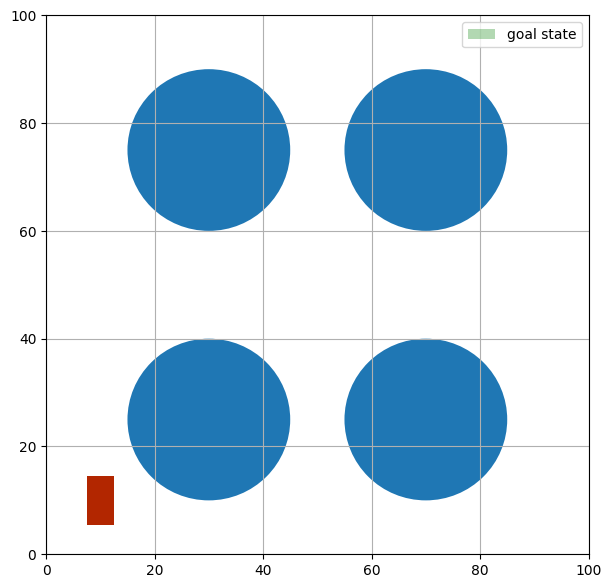

((array([10.17854581, 15.        ]), 0.0), (array([15.17854581, 14.32254599]), 21.176470588235293))


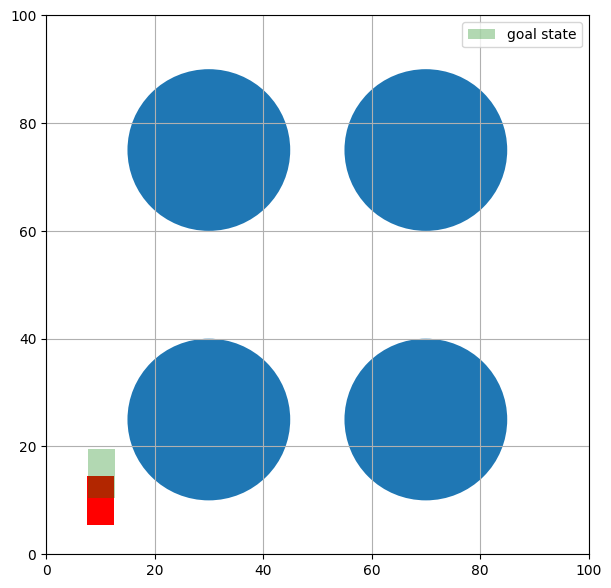

((array([10.17854581, 15.        ]), 0.0), (array([ 8.01864575, 20.        ]), 0.0))


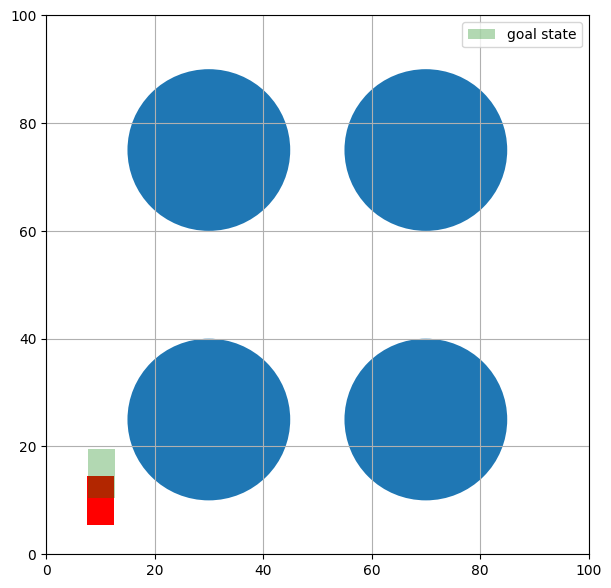

((array([ 8.01864575, 20.        ]), 0.0), (array([13.01864575, 25.        ]), 0.0))


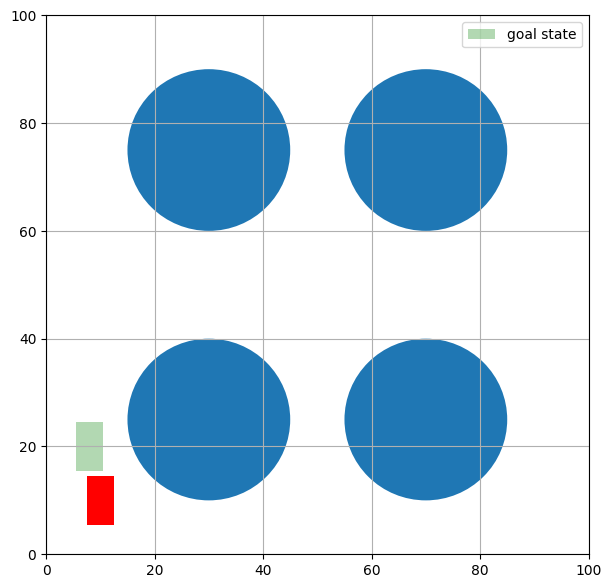

((array([15.17854581, 14.32254599]), 21.176470588235293), (array([20.17854581,  9.32254599]), 42.35294117647059))


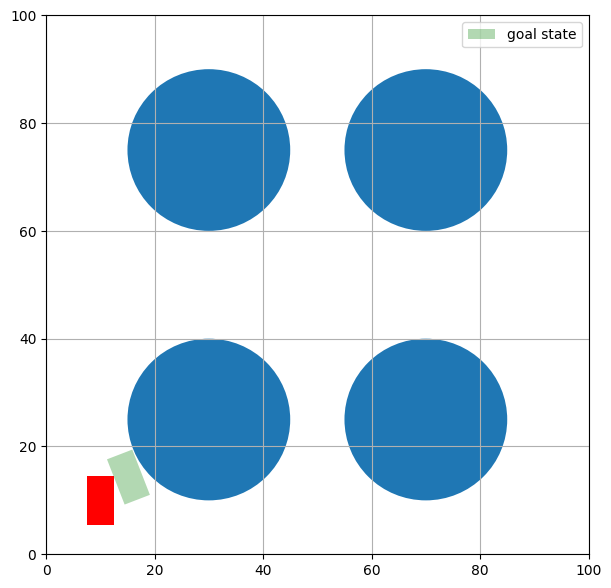

((array([13.01864575, 25.        ]), 0.0), (array([11.83783706, 30.        ]), 0.0))


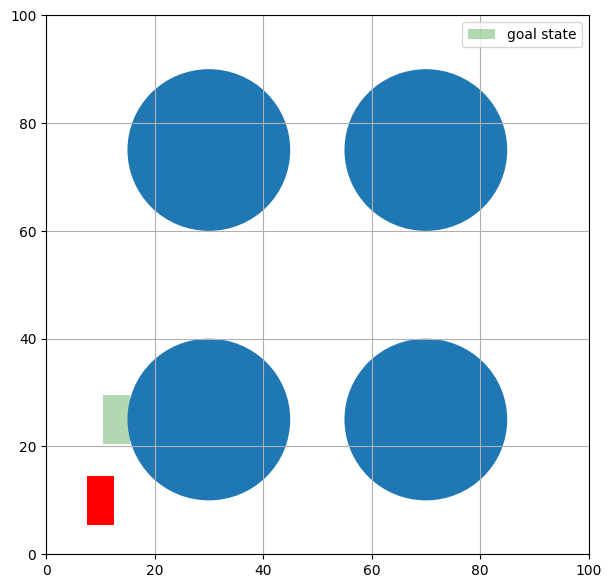

((array([20.17854581,  9.32254599]), 42.35294117647059), (array([25.17854581,  4.32254599]), 42.35294117647059))


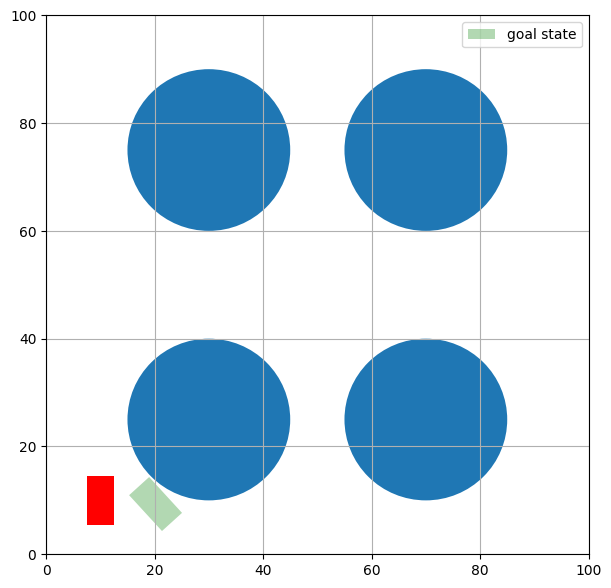

((array([ 8.01864575, 20.        ]), 0.0), (array([ 5.98331392, 24.05411065]), 0.0))


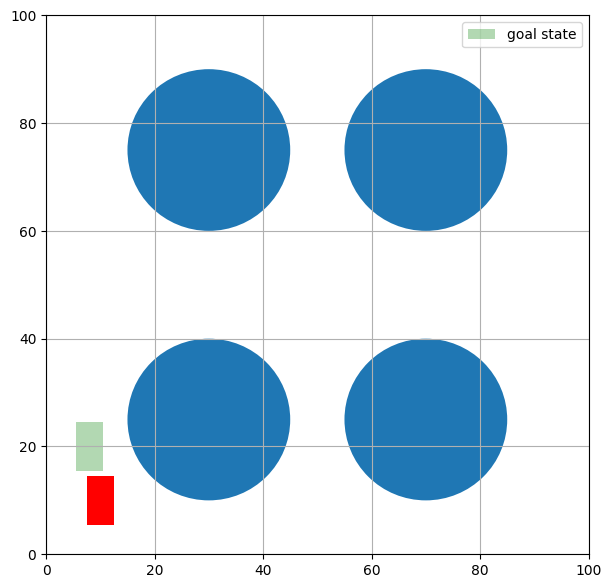

((array([25.17854581,  4.32254599]), 42.35294117647059), (array([26.67767421,  3.85714648]), 42.35294117647059))


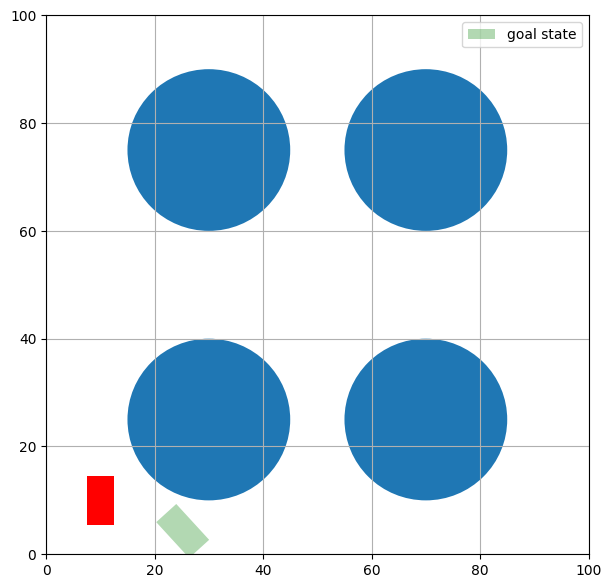

((array([11.83783706, 30.        ]), 0.0), (array([ 6.83783706, 35.        ]), 0.0))


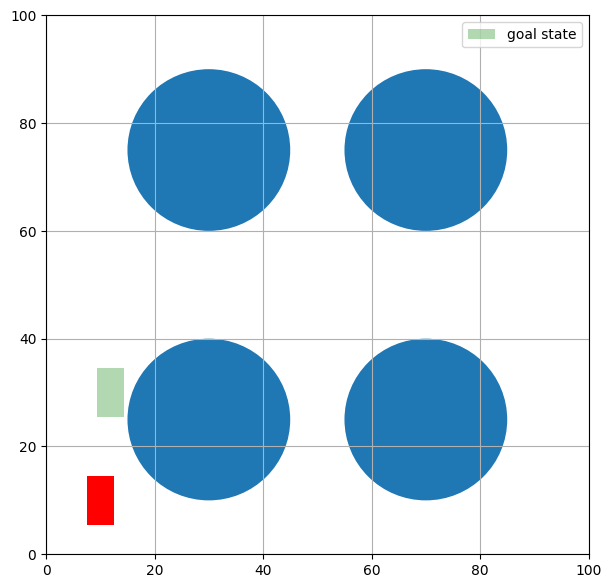

((array([26.67767421,  3.85714648]), 42.35294117647059), (array([31.67767421,  2.61999492]), 42.35294117647059))


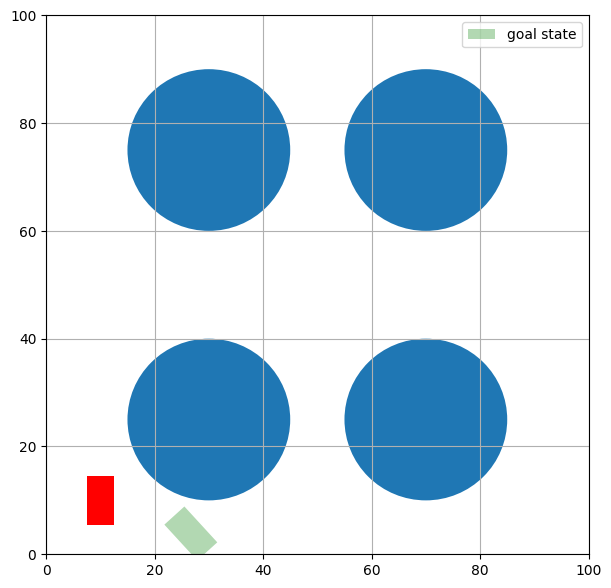

((array([ 6.83783706, 35.        ]), 0.0), (array([ 1.83783706, 33.83409712]), 0.0))


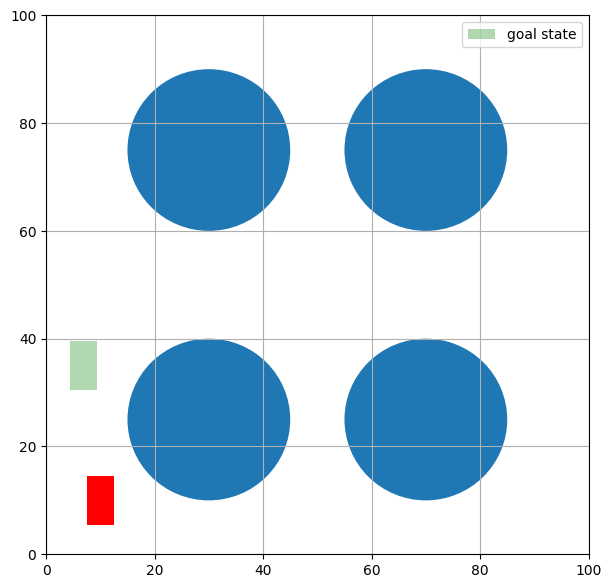

((array([31.67767421,  2.61999492]), 42.35294117647059), (array([36.67767421,  7.61999492]), 95.29411764705883))


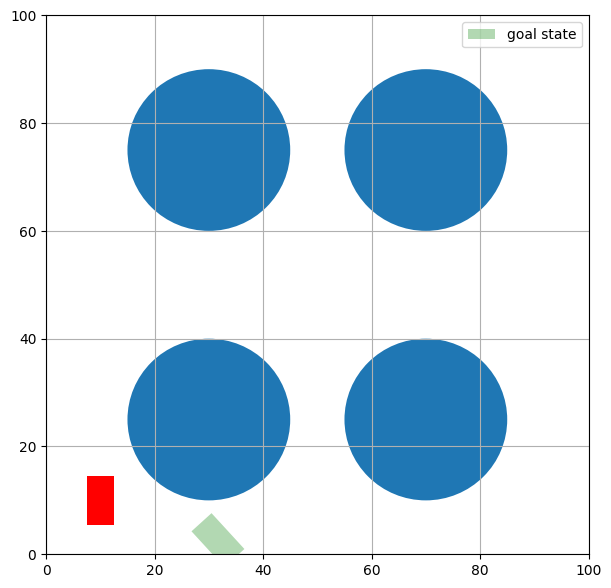

((array([ 6.83783706, 35.        ]), 0.0), (array([11.83783706, 40.        ]), 0.0))


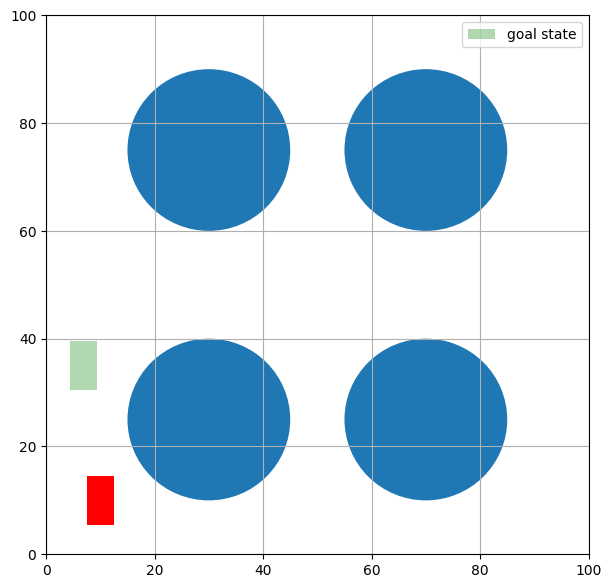

((array([11.83783706, 40.        ]), 0.0), (array([16.83783706, 45.        ]), 0.0))


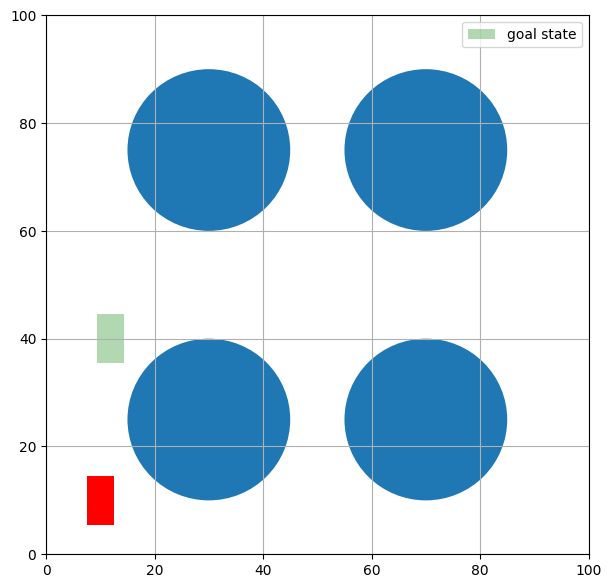

((array([16.83783706, 45.        ]), 0.0), (array([17.36900006, 50.        ]), 0.0))


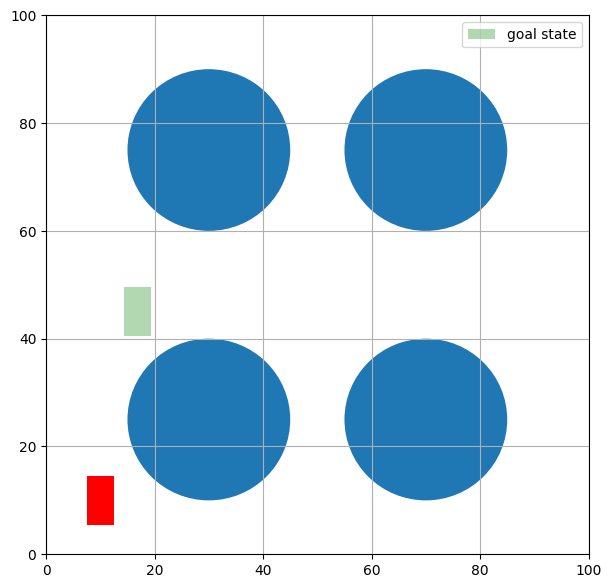

((array([17.36900006, 50.        ]), 0.0), (array([22.36900006, 55.        ]), 0.0))


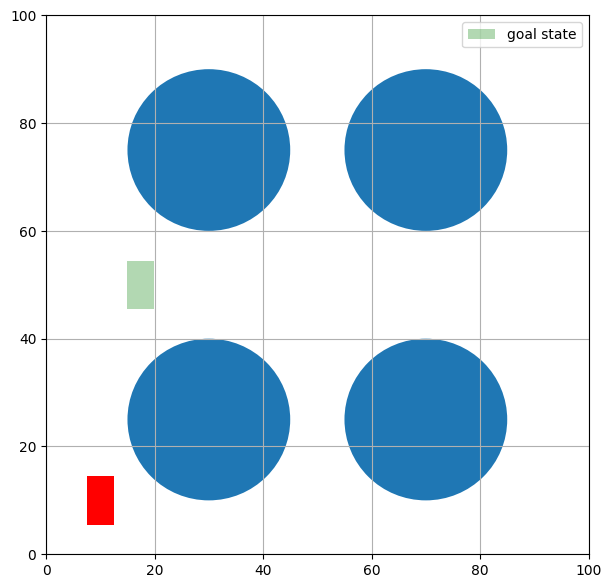

((array([22.36900006, 55.        ]), 0.0), (array([27.36900006, 50.        ]), 0.0))


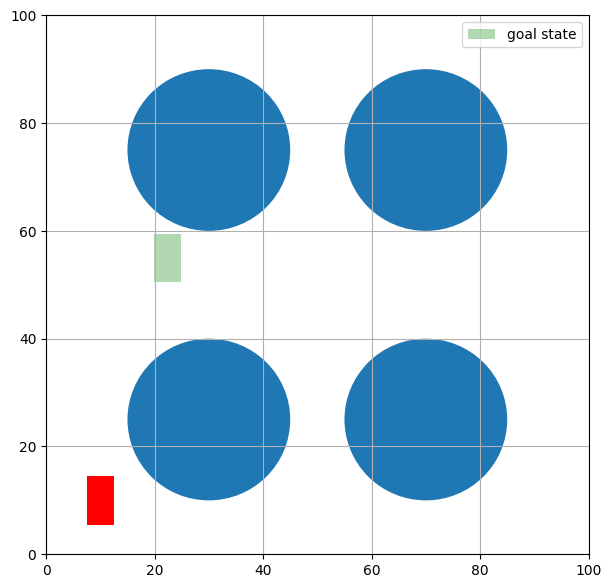

((array([27.36900006, 50.        ]), 0.0), (array([32.36900006, 45.        ]), 0.0))


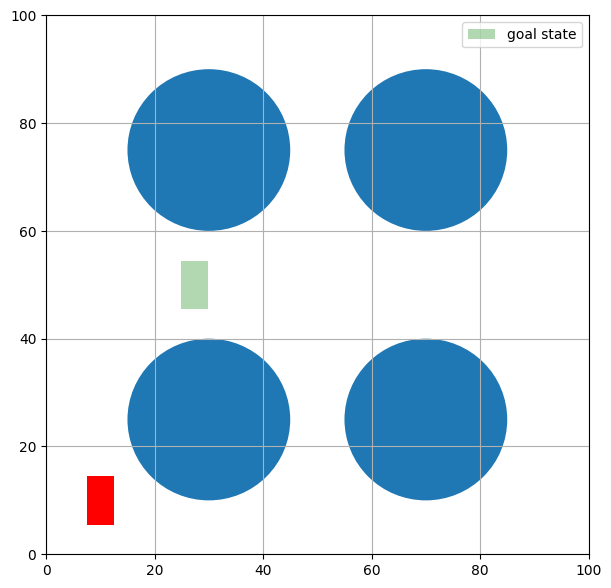

((array([22.36900006, 55.        ]), 0.0), (array([19.72857098, 60.        ]), 42.35294117647059))


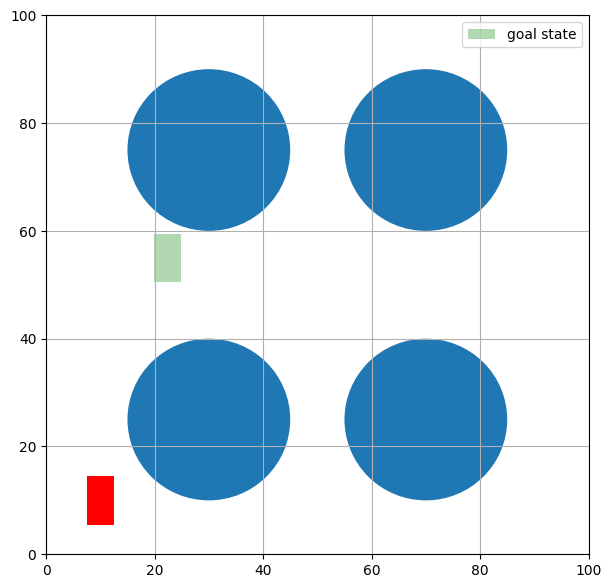

((array([32.36900006, 45.        ]), 0.0), (array([37.36900006, 41.11333984]), 63.529411764705884))


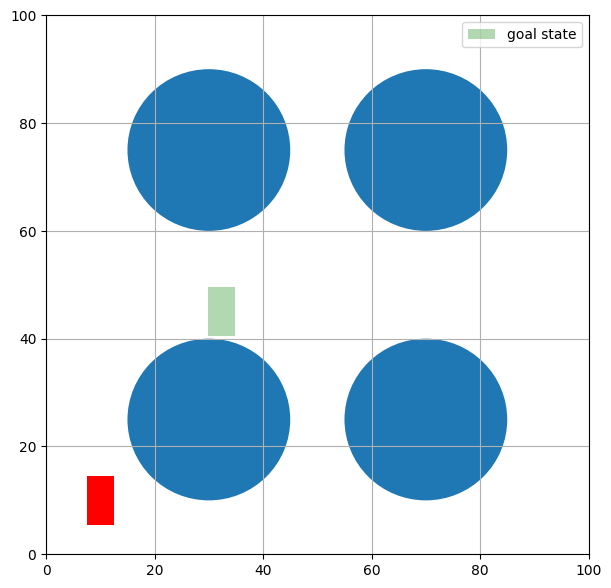

((array([27.36900006, 50.        ]), 0.0), (array([32.36900006, 55.        ]), 0.0))


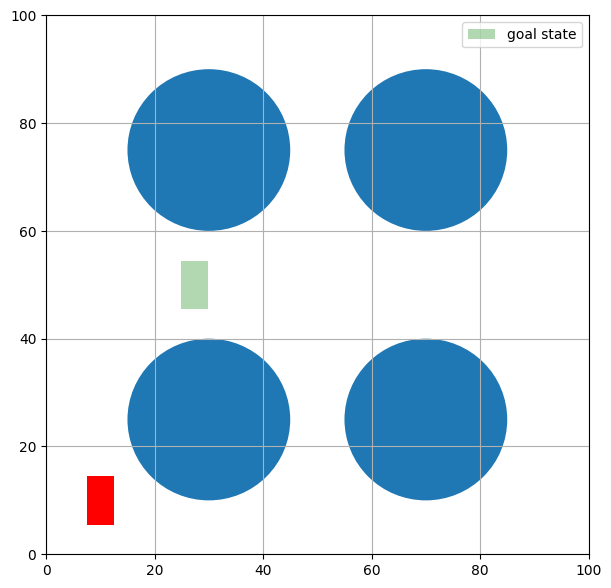

((array([11.83783706, 40.        ]), 0.0), (array([14.97947674, 35.68459135]), 127.05882352941177))


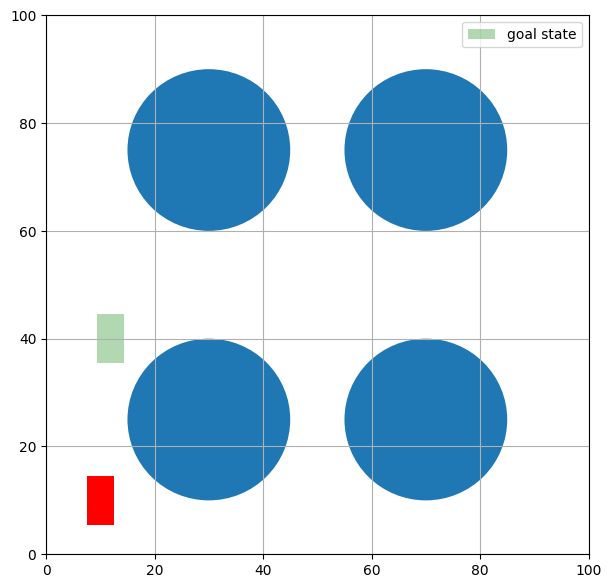

((array([20.17854581,  9.32254599]), 42.35294117647059), (array([15.87782786,  4.32254599]), 42.35294117647059))


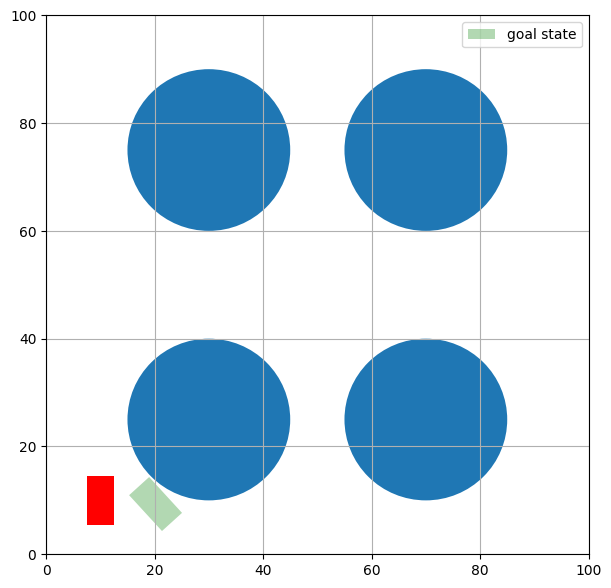

((array([37.36900006, 41.11333984]), 63.529411764705884), (array([42.36900006, 46.11333984]), 63.529411764705884))


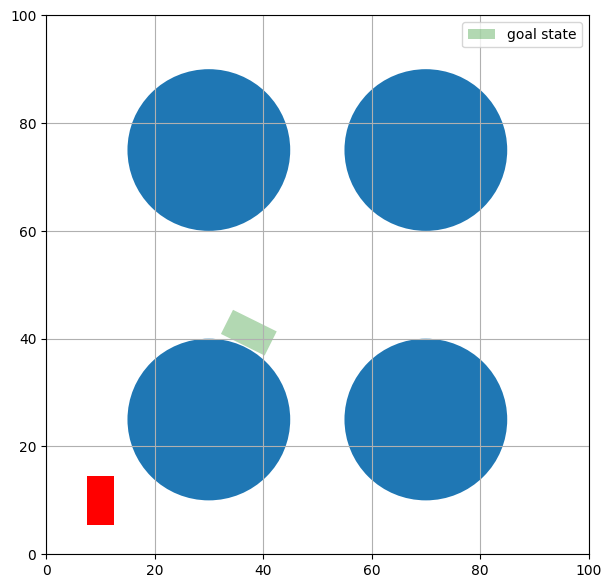

((array([42.36900006, 46.11333984]), 63.529411764705884), (array([47.36900006, 51.11333984]), 63.529411764705884))


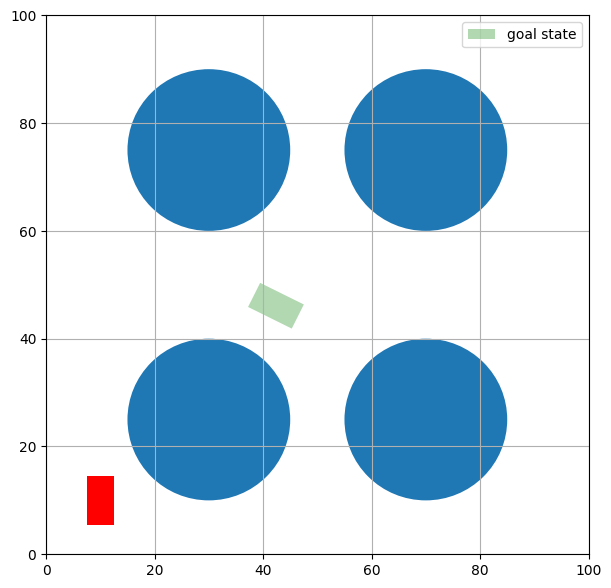

((array([47.36900006, 51.11333984]), 63.529411764705884), (array([52.36900006, 46.11333984]), 63.529411764705884))


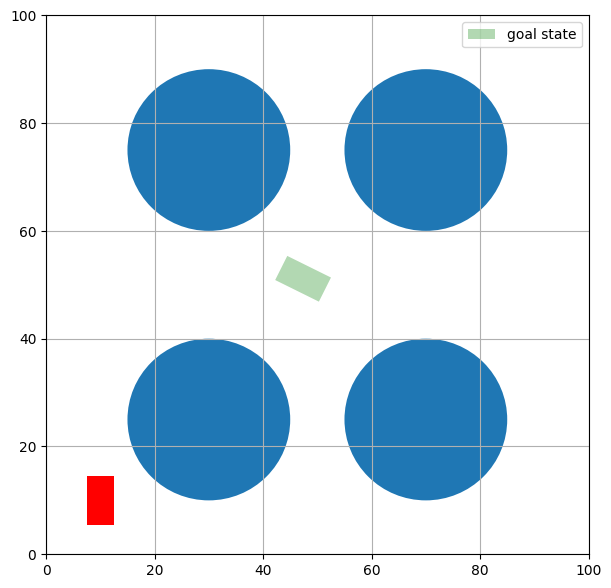

((array([52.36900006, 46.11333984]), 63.529411764705884), (array([57.36900006, 41.11333984]), 63.529411764705884))


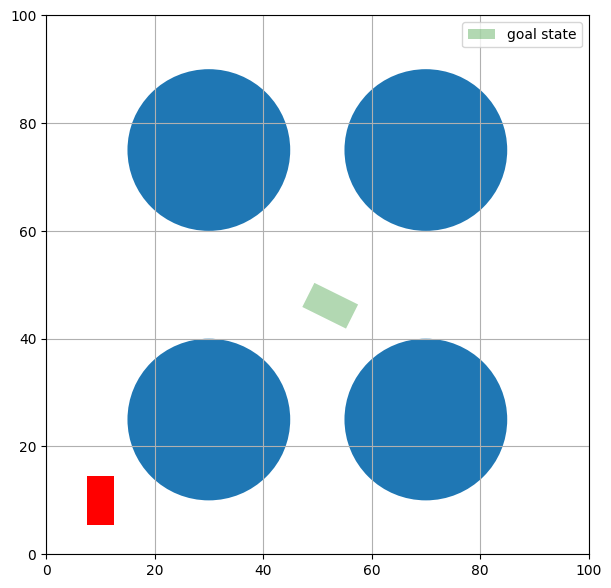

((array([57.36900006, 41.11333984]), 63.529411764705884), (array([62.36900006, 46.11333984]), 63.529411764705884))


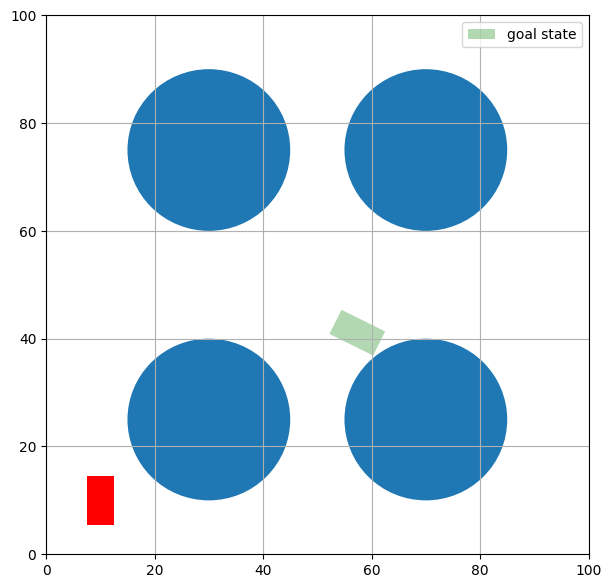

((array([62.36900006, 46.11333984]), 63.529411764705884), (array([67.36900006, 51.11333984]), 63.529411764705884))


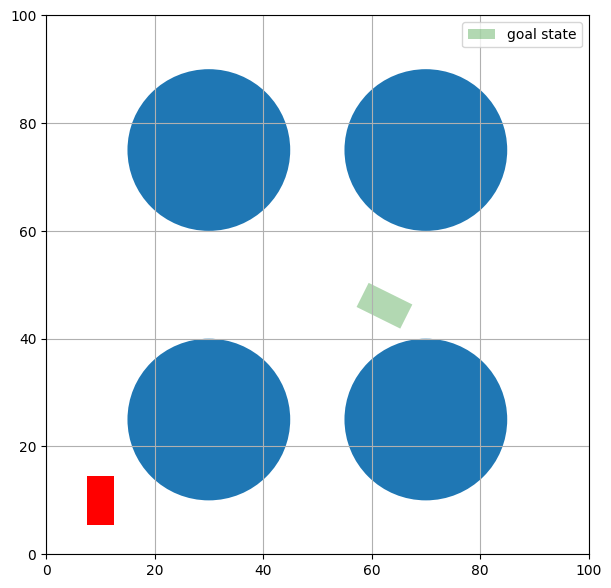

((array([67.36900006, 51.11333984]), 63.529411764705884), (array([72.36900006, 56.11333984]), 74.11764705882352))


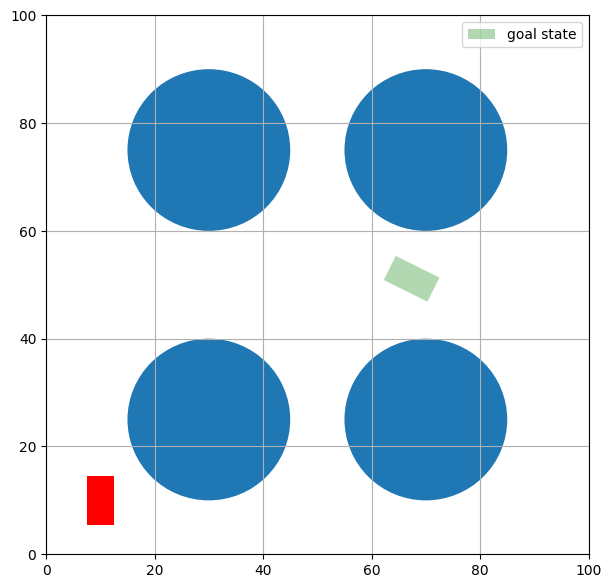

((array([36.67767421,  7.61999492]), 95.29411764705883), (array([41.67767421,  8.98125264]), 95.29411764705883))


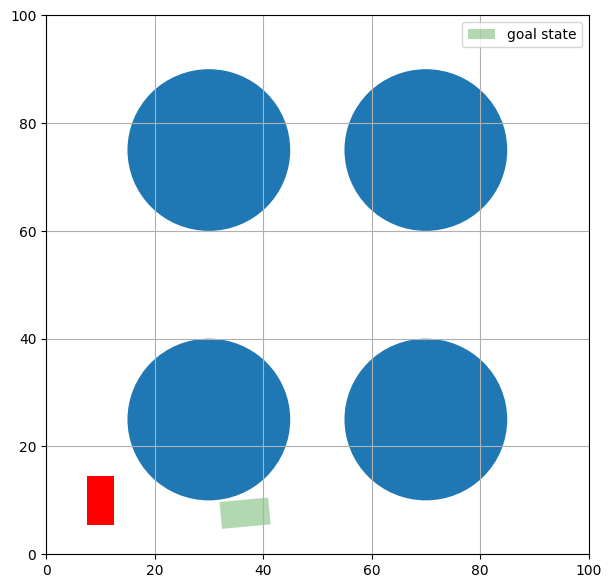

((array([47.36900006, 51.11333984]), 63.529411764705884), (array([45.18293453, 56.11333984]), 63.529411764705884))


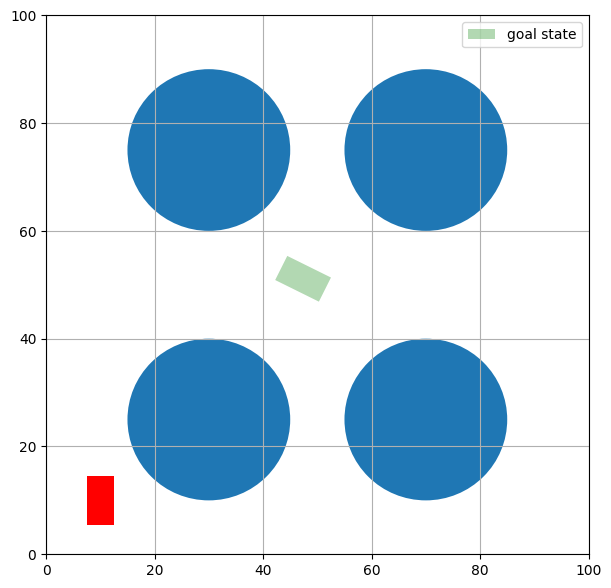

((array([57.36900006, 41.11333984]), 63.529411764705884), (array([60.39037525, 40.09488652]), 116.47058823529412))


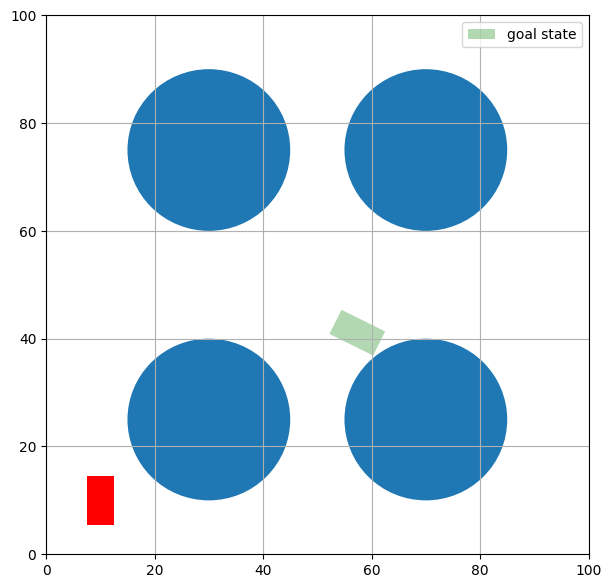

((array([45.18293453, 56.11333984]), 63.529411764705884), (array([50.18293453, 61.11333984]), 63.529411764705884))


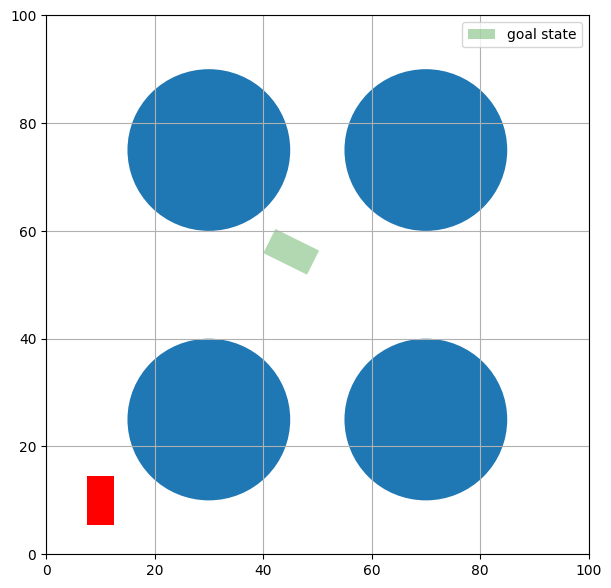

((array([50.18293453, 61.11333984]), 63.529411764705884), (array([45.18293453, 66.11333984]), 148.23529411764704))


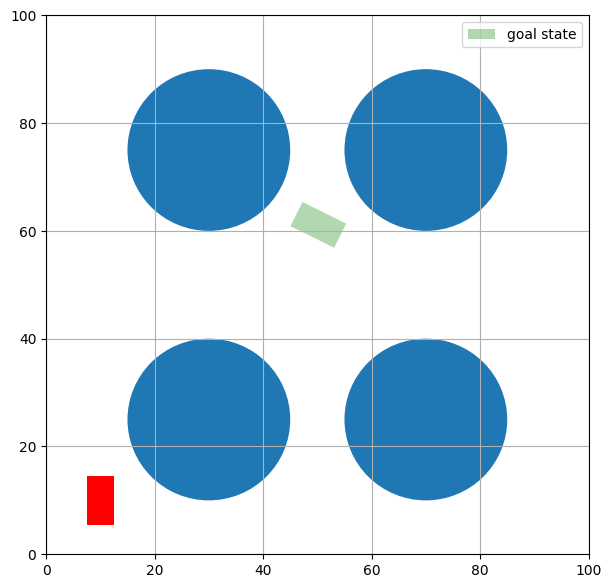

((array([19.72857098, 60.        ]), 42.35294117647059), (array([14.72857098, 62.68444884]), 42.35294117647059))


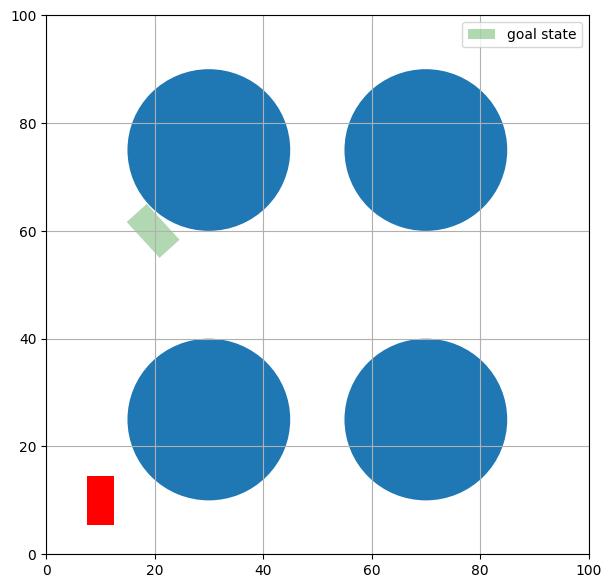

((array([45.18293453, 66.11333984]), 148.23529411764704), (array([49.89602345, 71.11333984]), 148.23529411764704))


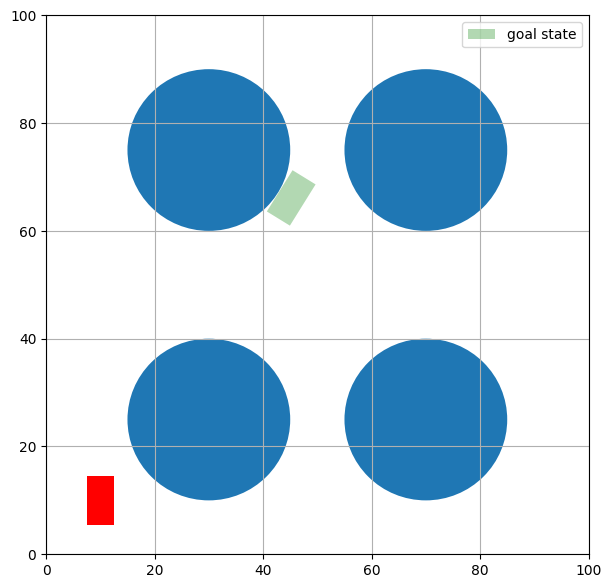

((array([36.67767421,  7.61999492]), 95.29411764705883), (array([40.64820552,  2.61999492]), 95.29411764705883))


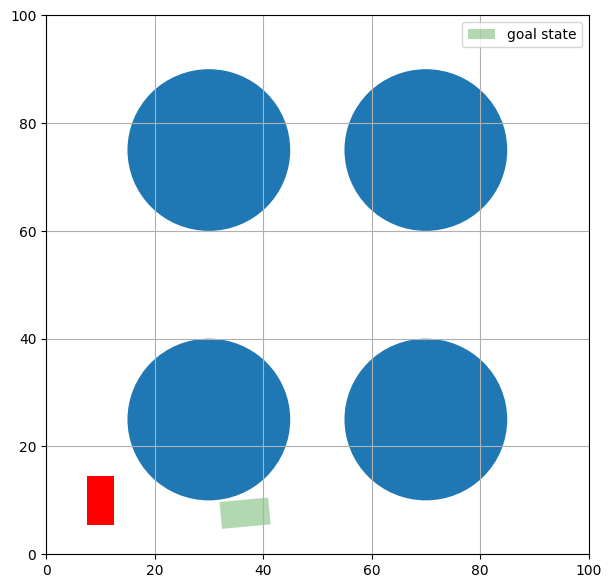

((array([41.67767421,  8.98125264]), 95.29411764705883), (array([43.57323652, 13.98125264]), 137.64705882352942))


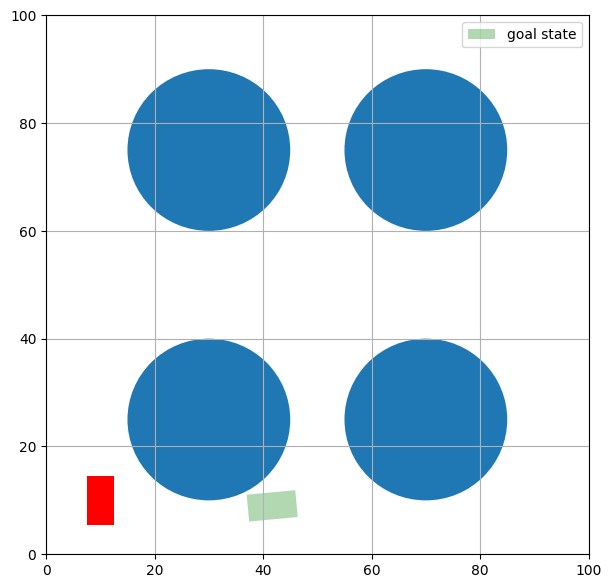

((array([67.36900006, 51.11333984]), 63.529411764705884), (array([72.36900006, 46.11333984]), 63.529411764705884))


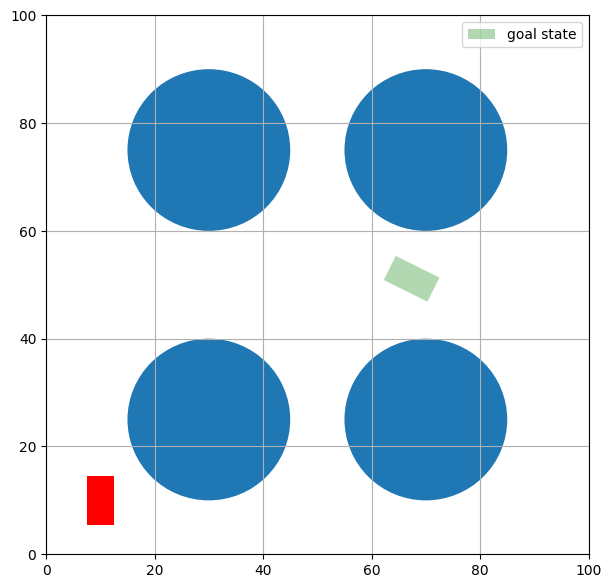

((array([14.72857098, 62.68444884]), 42.35294117647059), (array([ 9.72857098, 57.68444884]), 42.35294117647059))


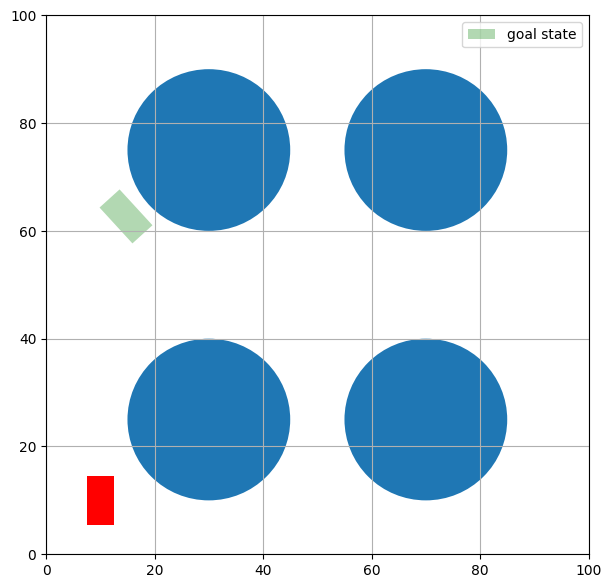

((array([10, 10]), 0.0), (array([13.76113848, 10.25107993]), 0.0))


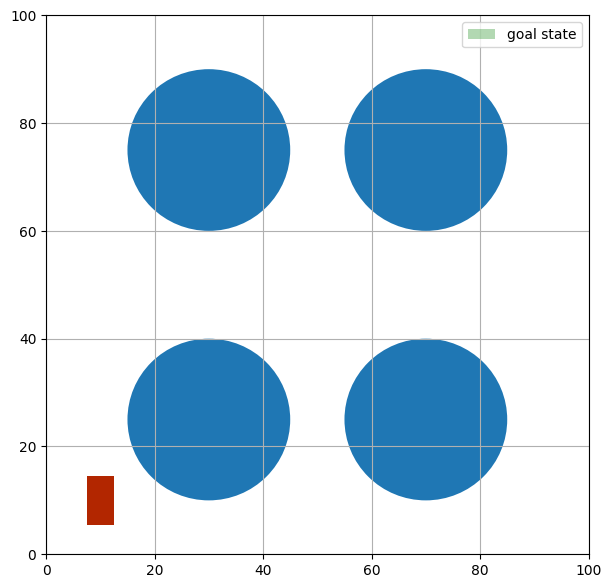

((array([43.57323652, 13.98125264]), 137.64705882352942), (array([48.57323652, 17.05220107]), 137.64705882352942))


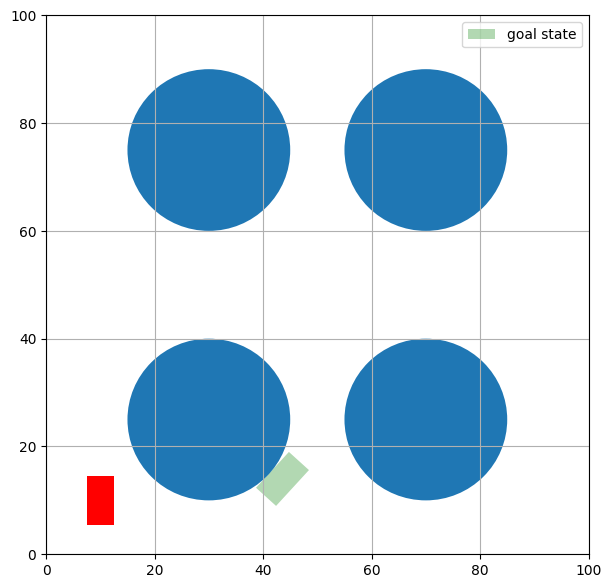

((array([ 9.72857098, 57.68444884]), 42.35294117647059), (array([ 6.41321713, 53.40200536]), 42.35294117647059))


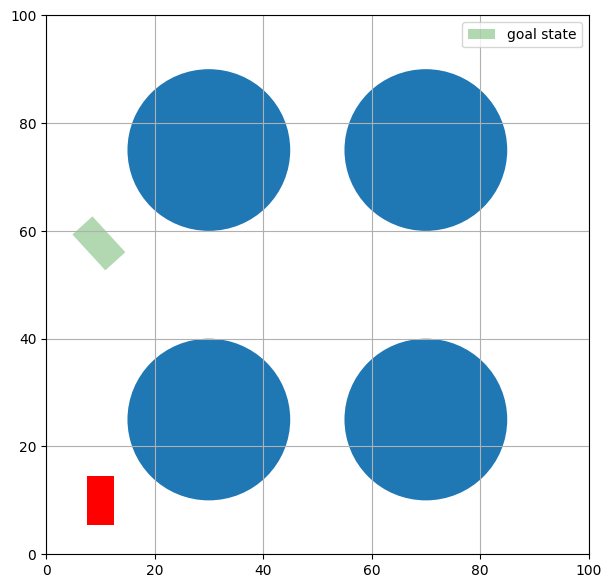

((array([48.57323652, 17.05220107]), 137.64705882352942), (array([53.57323652, 12.05220107]), 137.64705882352942))


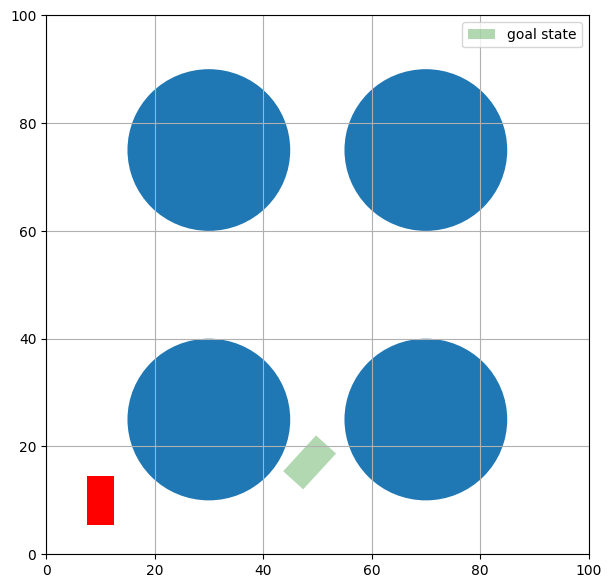

((array([32.36900006, 55.        ]), 0.0), (array([31.93815048, 51.87395523]), 0.0))


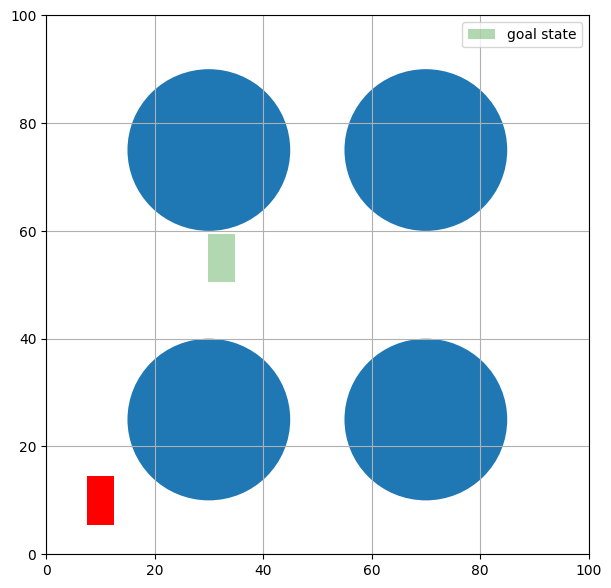

((array([25.17854581,  4.32254599]), 42.35294117647059), (array([24.81217912,  7.59673352]), 63.529411764705884))


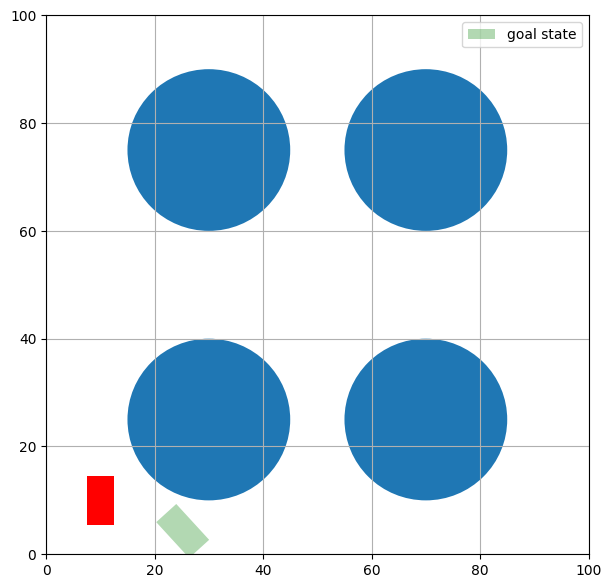

((array([31.67767421,  2.61999492]), 42.35294117647059), (array([30.3629665 ,  4.02269886]), 42.35294117647059))


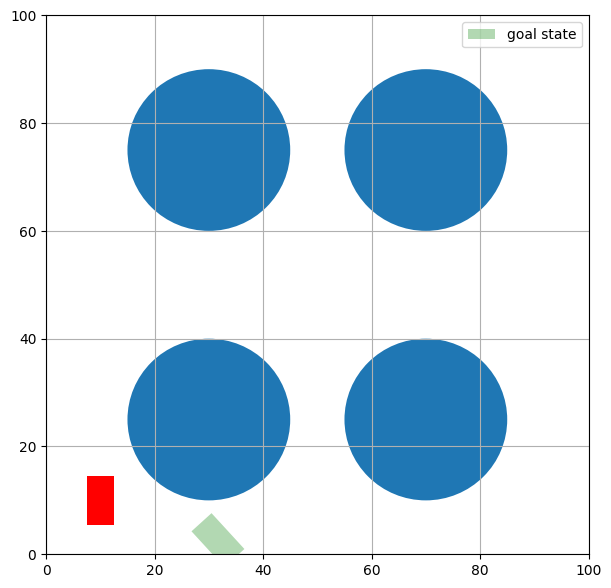

((array([ 9.72857098, 57.68444884]), 42.35294117647059), (array([ 4.72857098, 62.52785522]), 42.35294117647059))


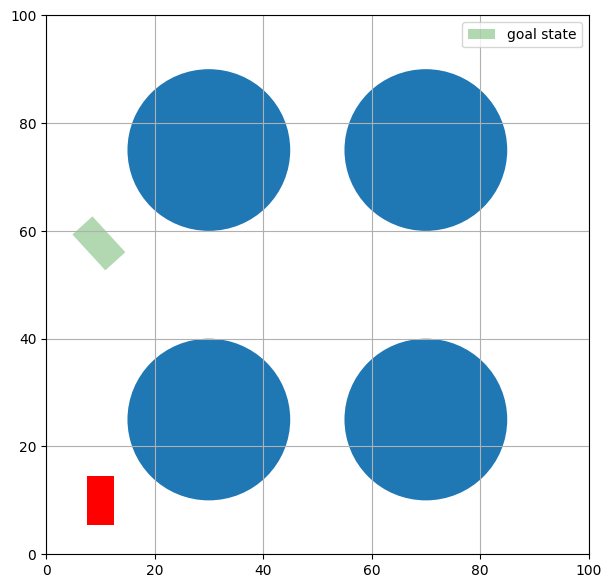

((array([ 4.72857098, 62.52785522]), 42.35294117647059), (array([ 0.85576686, 67.52785522]), 42.35294117647059))


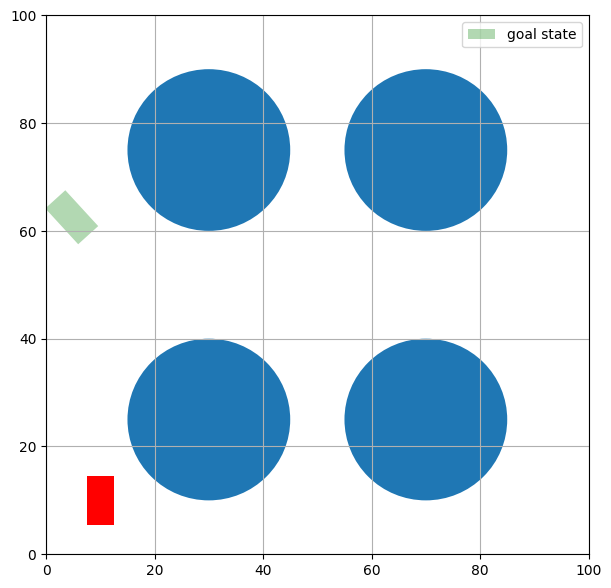

((array([72.36900006, 46.11333984]), 63.529411764705884), (array([77.36900006, 48.41398719]), 63.529411764705884))


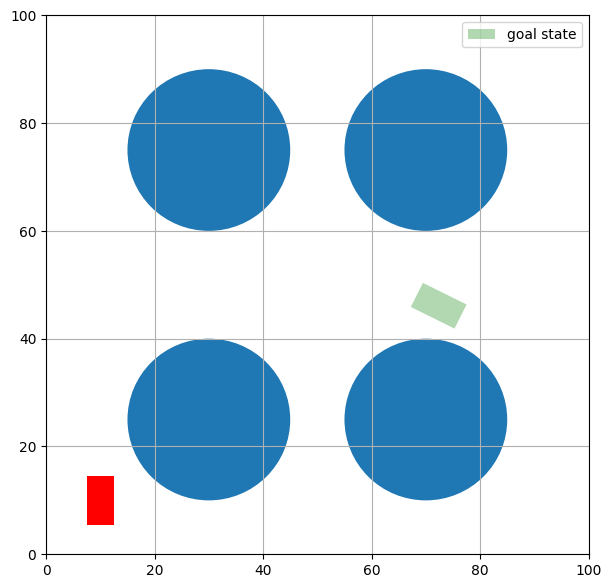

((array([13.01864575, 25.        ]), 0.0), (array([11.71500342, 23.87382648]), 0.0))


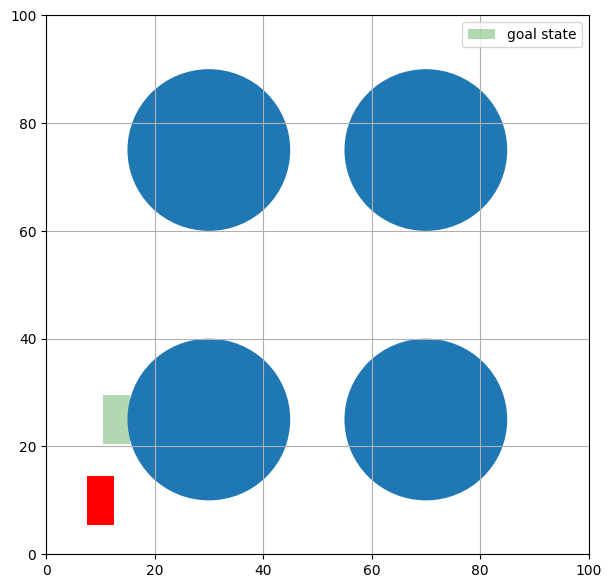

((array([30.3629665 ,  4.02269886]), 42.35294117647059), (array([30.60213931,  4.84956357]), 42.35294117647059))


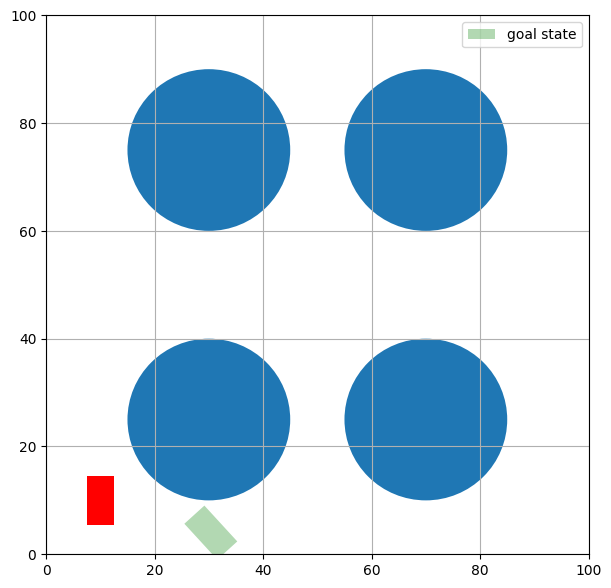

((array([30.3629665 ,  4.02269886]), 42.35294117647059), (array([30.60213931,  4.84956357]), 42.35294117647059))


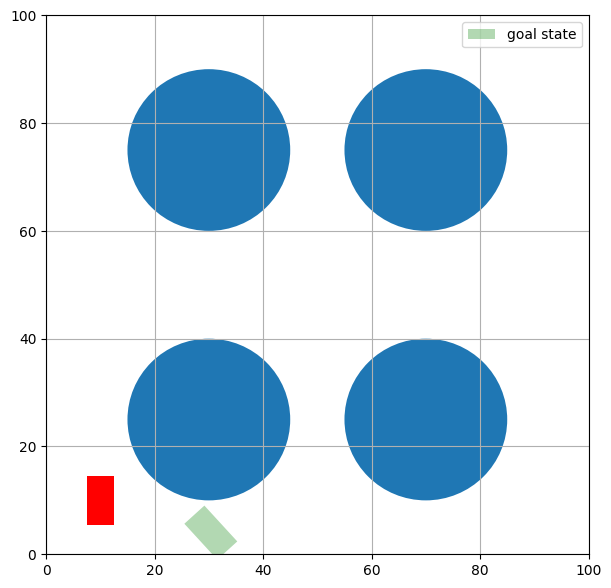

((array([62.36900006, 46.11333984]), 63.529411764705884), (array([58.4502886 , 51.11333984]), 63.529411764705884))


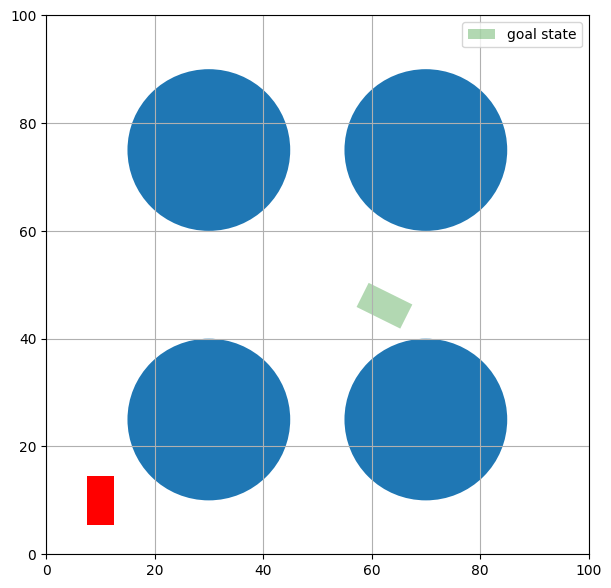

((array([50.18293453, 61.11333984]), 63.529411764705884), (array([55.18293453, 62.37499512]), 63.529411764705884))


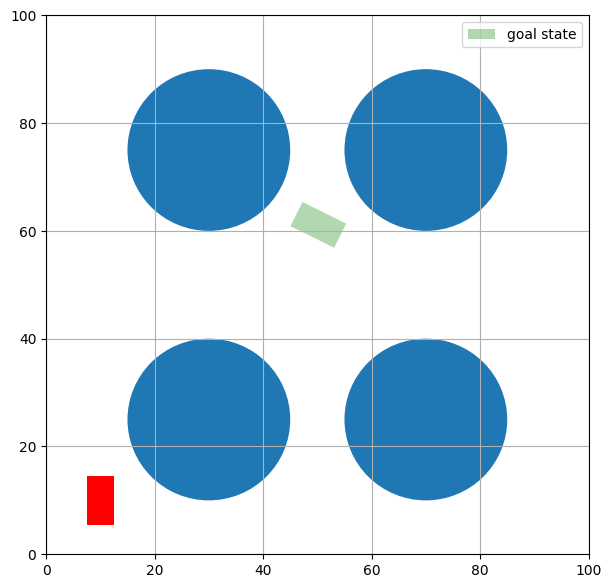

((array([11.83783706, 40.        ]), 0.0), (array([ 8.25552826, 45.        ]), 0.0))


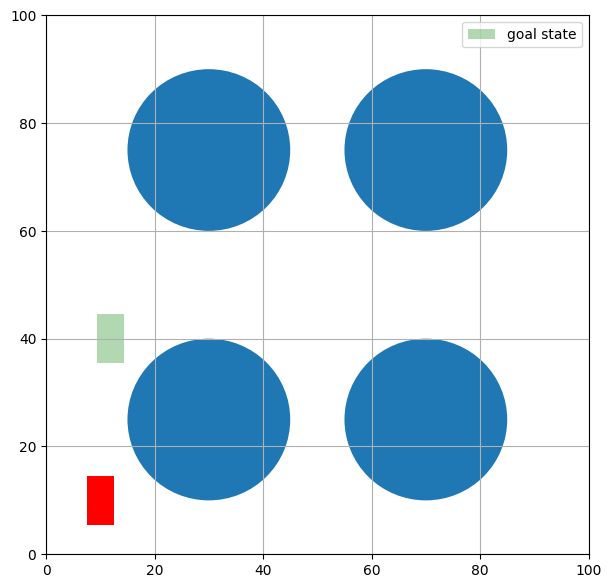

((array([ 0.85576686, 67.52785522]), 42.35294117647059), (array([ 3.56968824, 69.65057631]), 42.35294117647059))


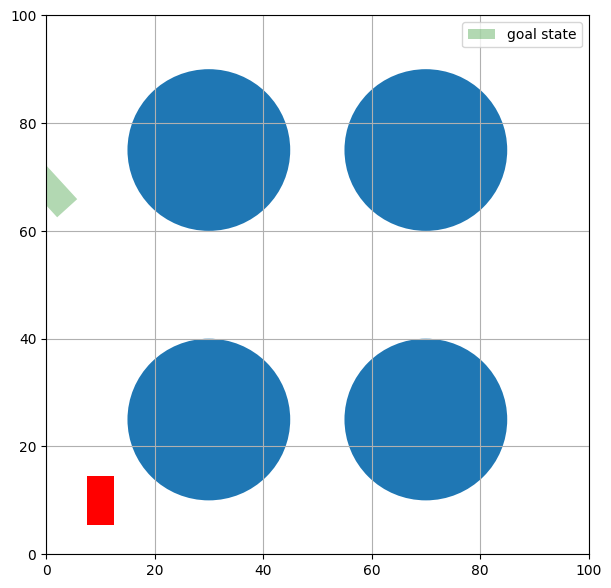

((array([53.57323652, 12.05220107]), 137.64705882352942), (array([58.57323652,  9.46579574]), 31.764705882352942))


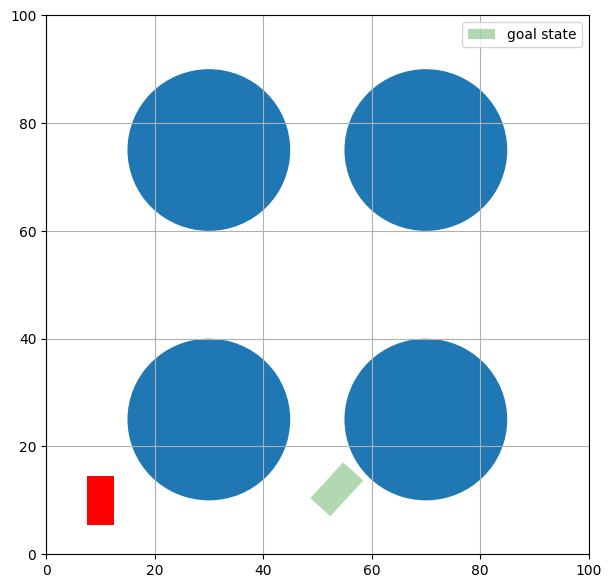

((array([11.83783706, 30.        ]), 0.0), (array([11.69373181, 32.5446126 ]), 0.0))


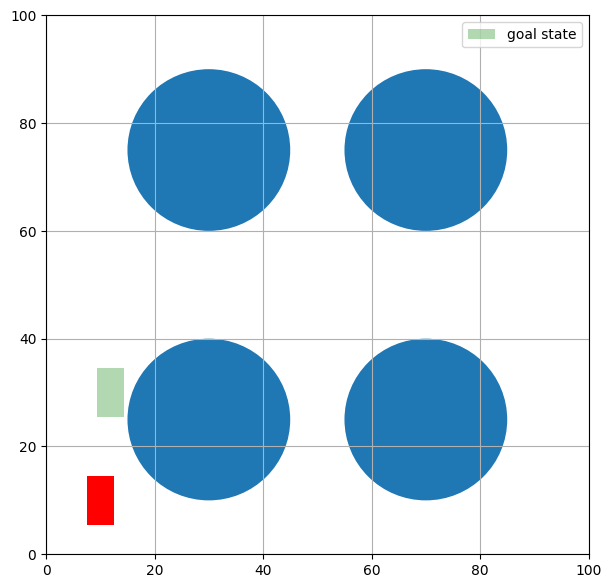

((array([42.36900006, 46.11333984]), 63.529411764705884), (array([40.24937216, 46.84221542]), 63.529411764705884))


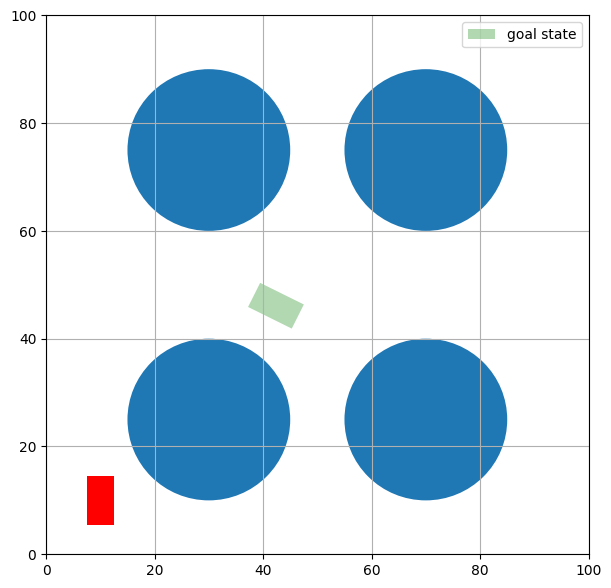

((array([ 3.56968824, 69.65057631]), 42.35294117647059), (array([ 8.56968824, 74.65057631]), 42.35294117647059))


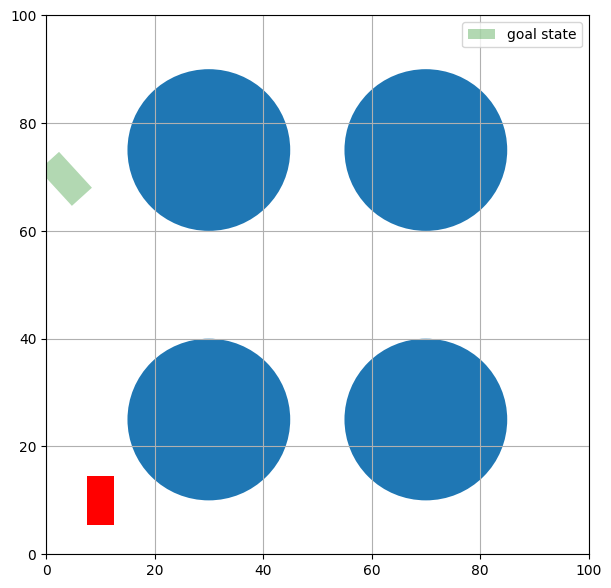

((array([77.36900006, 48.41398719]), 63.529411764705884), (array([82.36900006, 43.41398719]), 63.529411764705884))


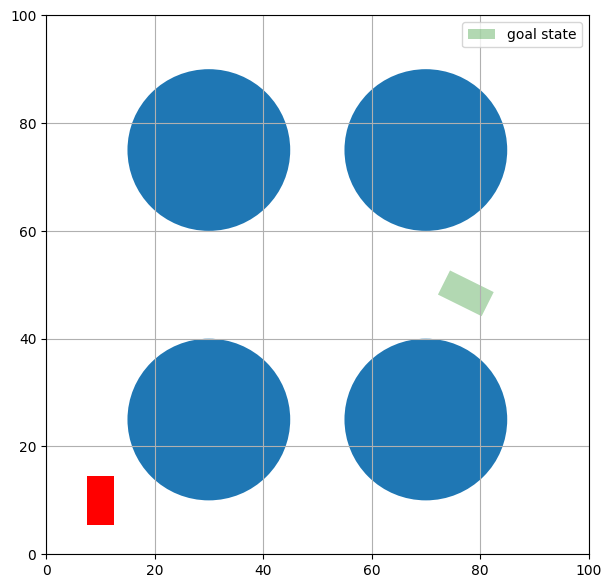

((array([58.57323652,  9.46579574]), 31.764705882352942), (array([56.61941793,  7.16330356]), 31.764705882352942))


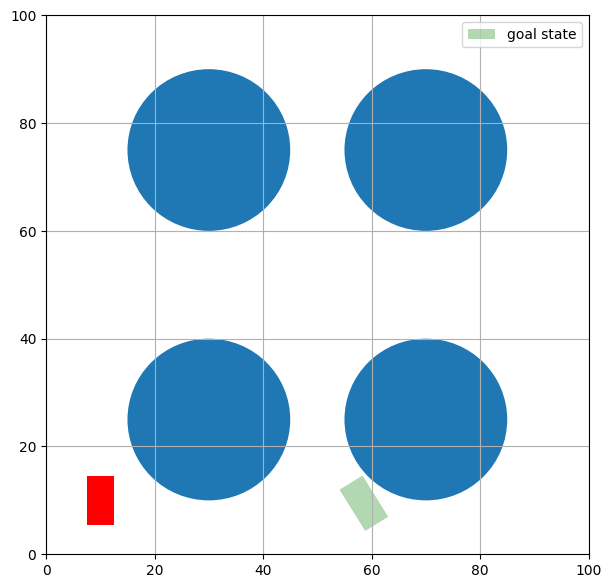

((array([56.61941793,  7.16330356]), 31.764705882352942), (array([61.61941793,  2.39327358]), 31.764705882352942))


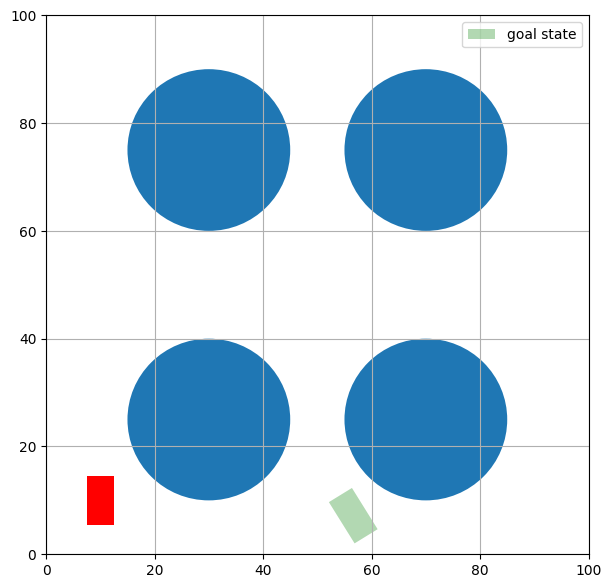

((array([26.67767421,  3.85714648]), 42.35294117647059), (array([27.35516608,  1.44934261]), 42.35294117647059))


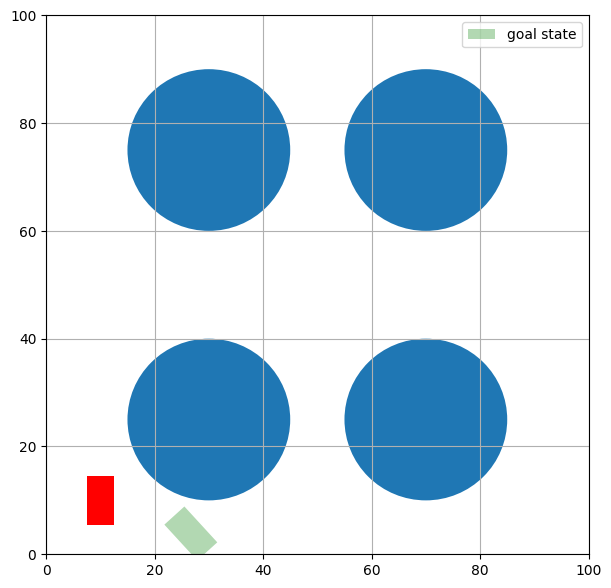

((array([49.89602345, 71.11333984]), 148.23529411764704), (array([52.67560567, 76.11333984]), 0.0))


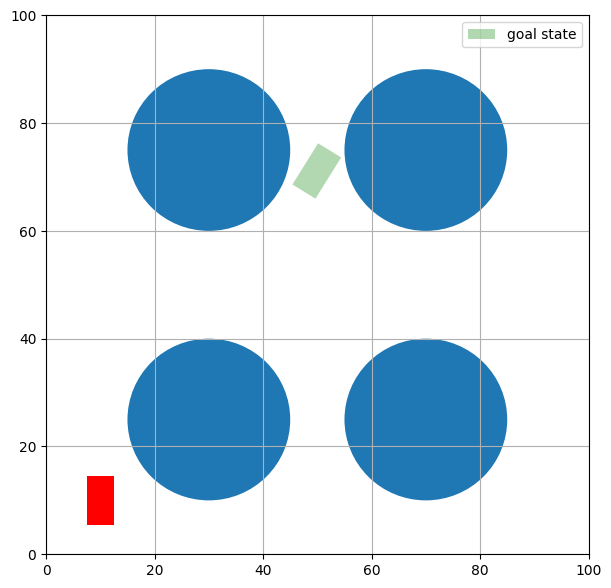

((array([72.36900006, 56.11333984]), 74.11764705882352), (array([69.41019434, 56.58251327]), 74.11764705882352))


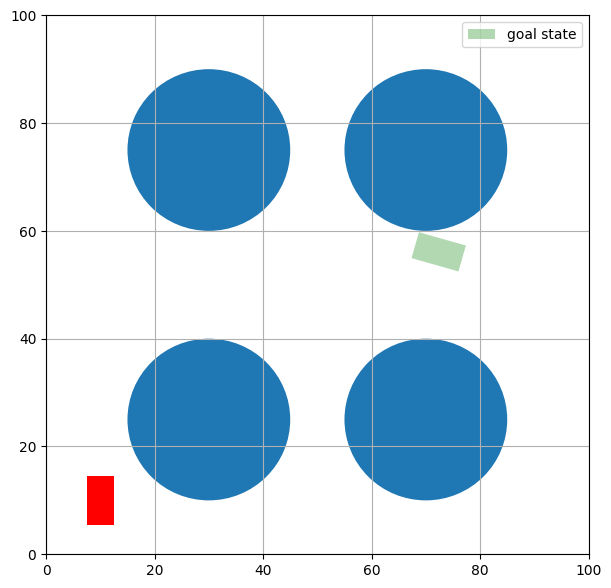

((array([ 1.83783706, 33.83409712]), 0.0), (array([ 2.36889431, 29.89341134]), 0.0))


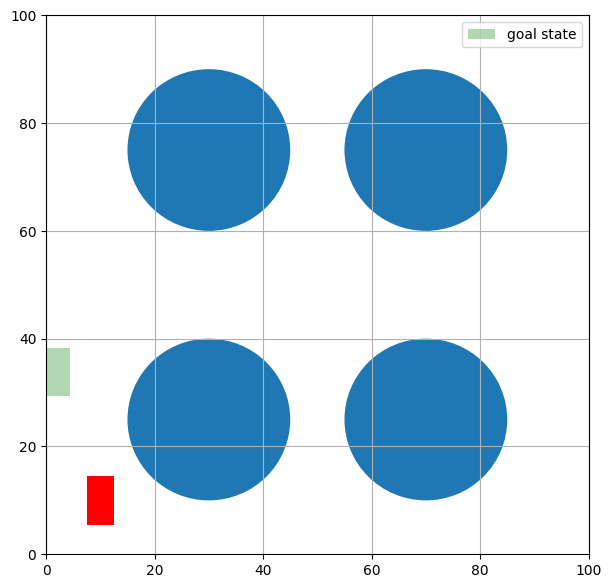

((array([82.36900006, 43.41398719]), 63.529411764705884), (array([80.30985317, 38.41398719]), 52.94117647058823))


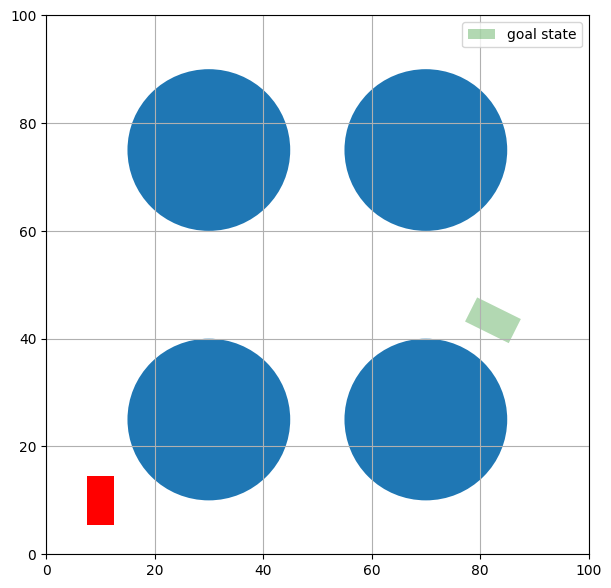

((array([43.57323652, 13.98125264]), 137.64705882352942), (array([44.14819197, 13.82433512]), 137.64705882352942))


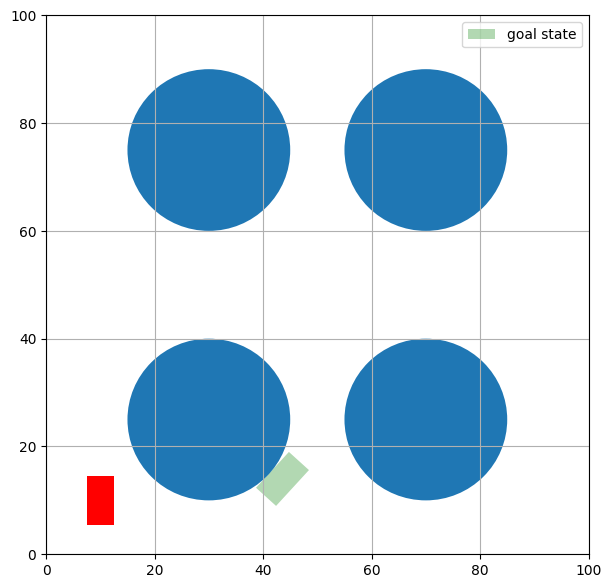

((array([43.57323652, 13.98125264]), 137.64705882352942), (array([44.14819197, 13.82433512]), 137.64705882352942))


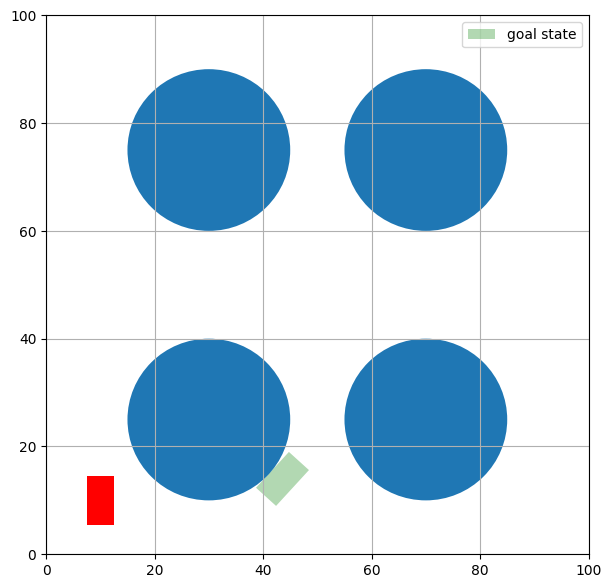

((array([ 8.01864575, 20.        ]), 0.0), (array([ 7.79265081, 17.36116454]), 0.0))


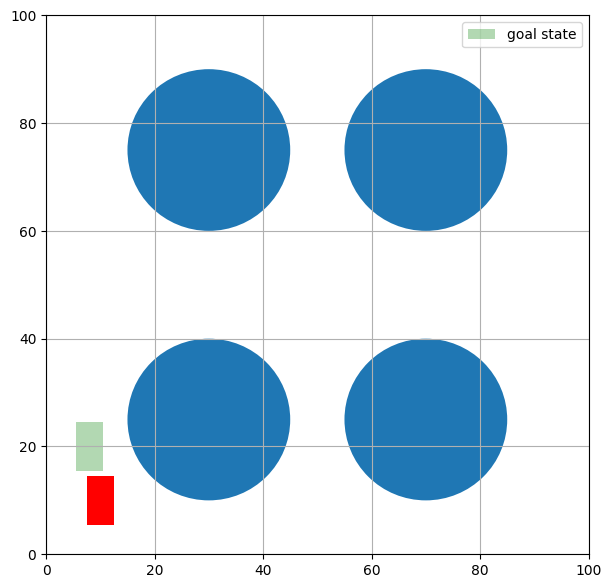

((array([52.67560567, 76.11333984]), 0.0), (array([47.67560567, 81.11333984]), 0.0))


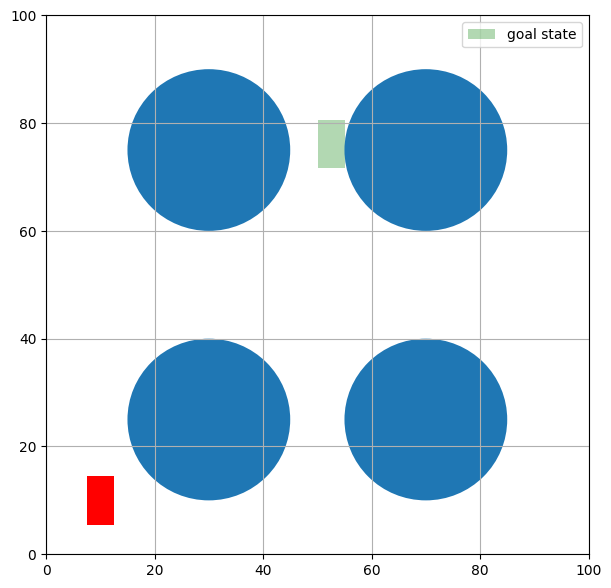

((array([61.61941793,  2.39327358]), 31.764705882352942), (array([66.61941793,  7.39327358]), 74.11764705882352))


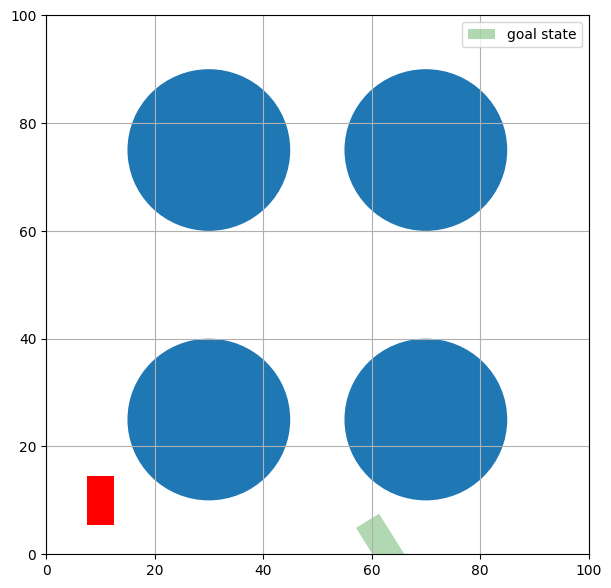

((array([16.83783706, 45.        ]), 0.0), (array([16.73932571, 40.53277793]), 0.0))


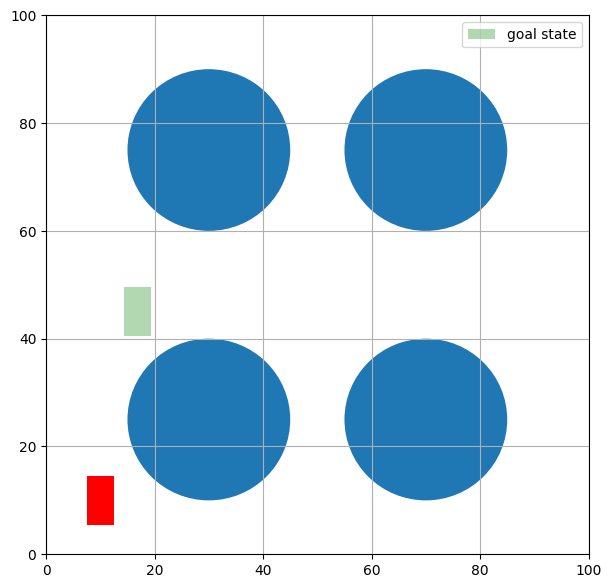

((array([ 5.98331392, 24.05411065]), 0.0), (array([ 5.41557225, 23.12619637]), 0.0))


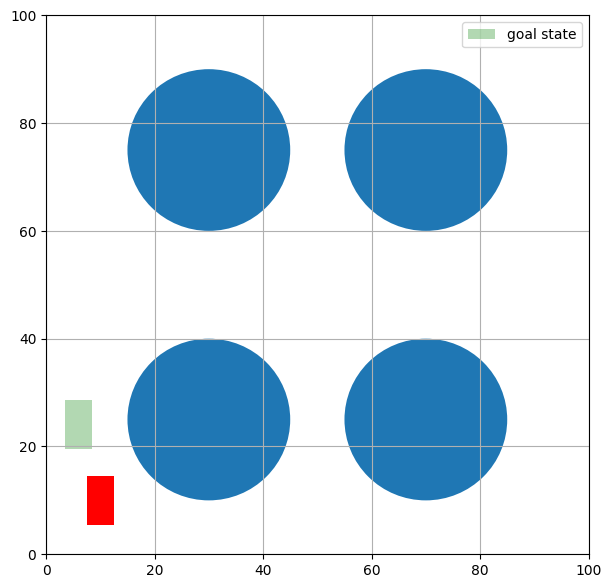

((array([49.89602345, 71.11333984]), 148.23529411764704), (array([51.52438723, 67.36705784]), 0.0))


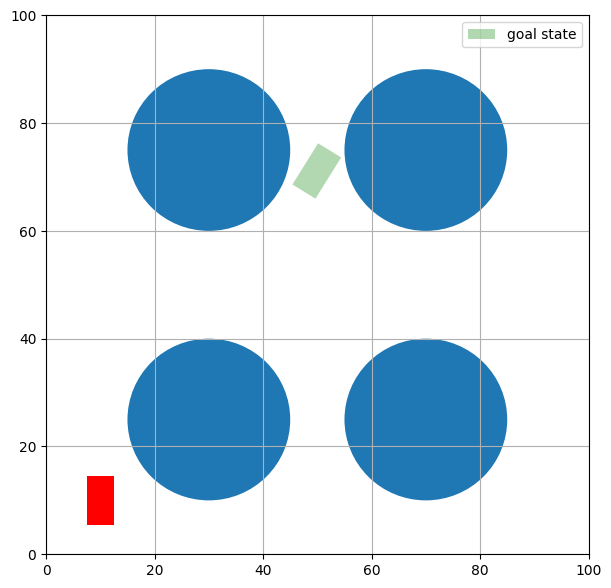

((array([57.36900006, 41.11333984]), 63.529411764705884), (array([52.36900006, 36.11333984]), 63.529411764705884))


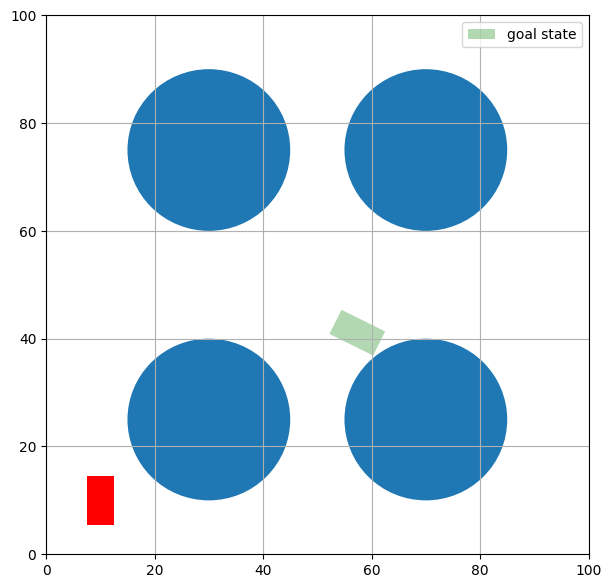

((array([77.36900006, 48.41398719]), 63.529411764705884), (array([80.30748137, 53.41398719]), 63.529411764705884))


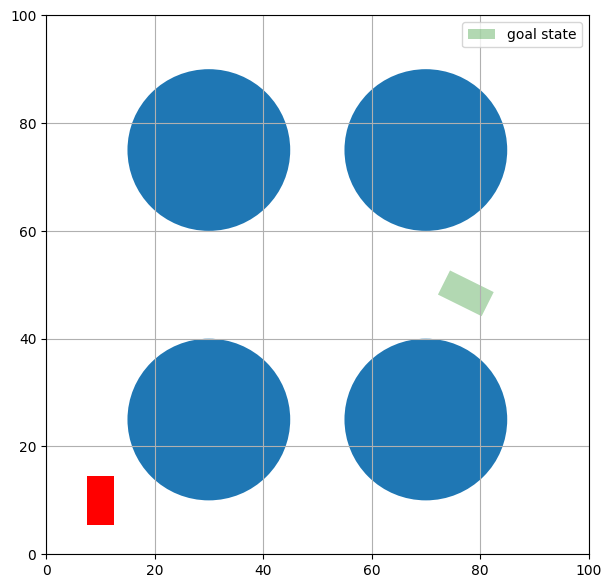

((array([10, 10]), 0.0), (array([8.3930053, 5.       ]), 0.0))


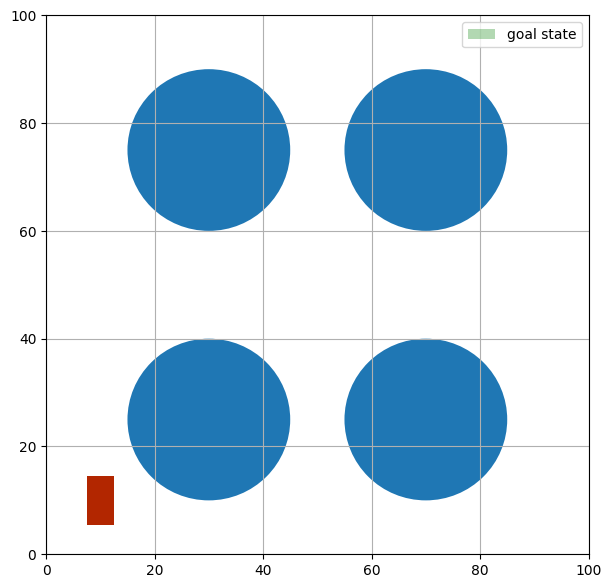

((array([58.4502886 , 51.11333984]), 63.529411764705884), (array([57.15510539, 48.58450129]), 63.529411764705884))


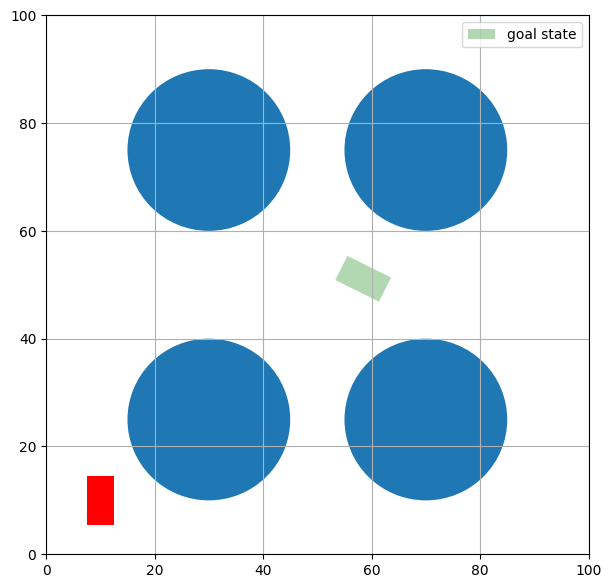

((array([69.41019434, 56.58251327]), 74.11764705882352), (array([69.67858118, 53.83993266]), 74.11764705882352))


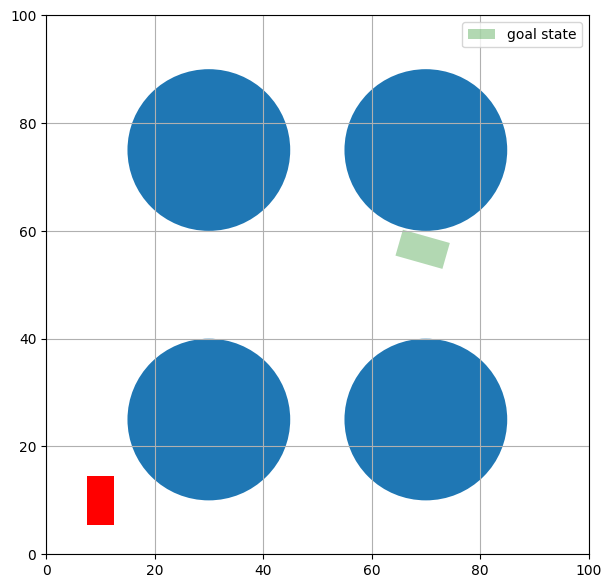

((array([ 5.41557225, 23.12619637]), 0.0), (array([ 3.31717416, 24.55013924]), 0.0))


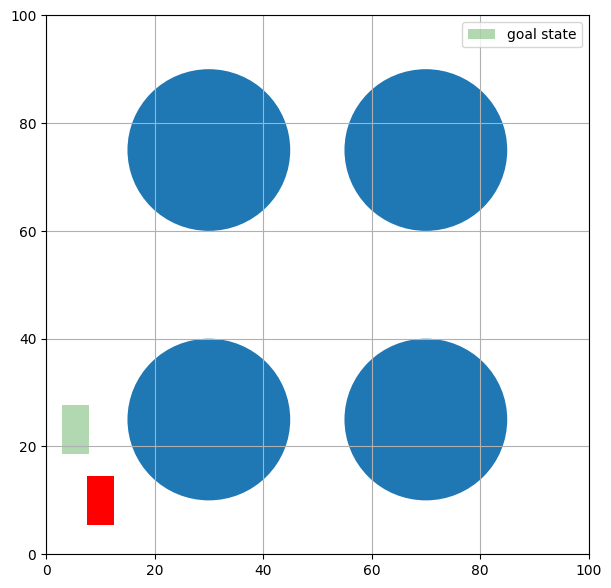

((array([80.30748137, 53.41398719]), 63.529411764705884), (array([85.30748137, 58.41398719]), 63.529411764705884))


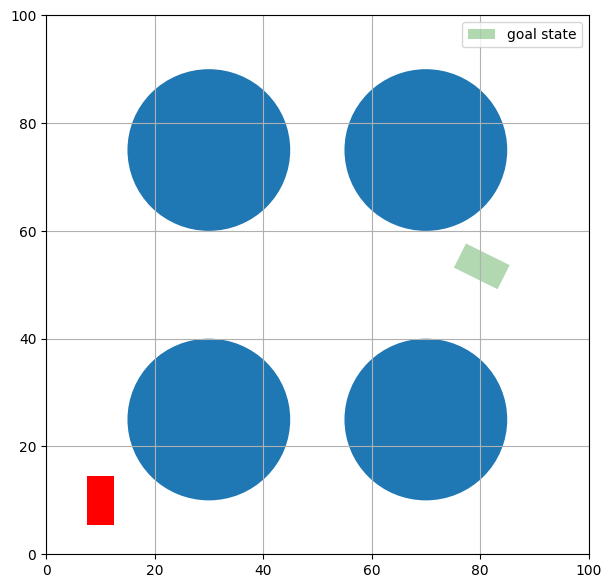

((array([ 2.36889431, 29.89341134]), 0.0), (array([ 4.77481787, 29.62335753]), 0.0))


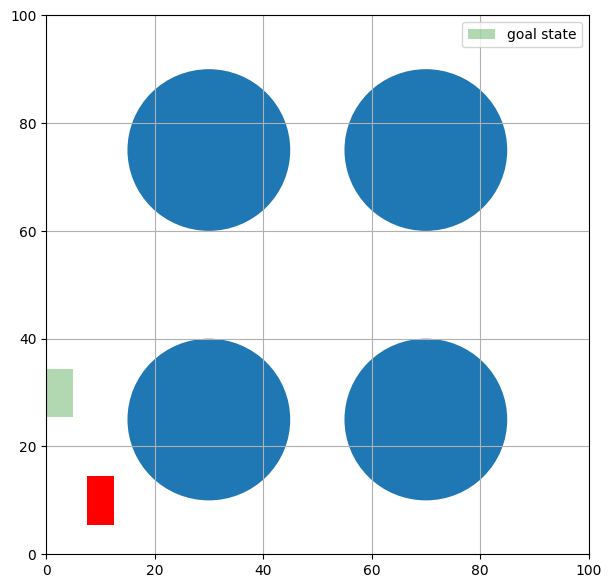

((array([55.18293453, 62.37499512]), 63.529411764705884), (array([54.56177851, 64.72416371]), 21.176470588235293))


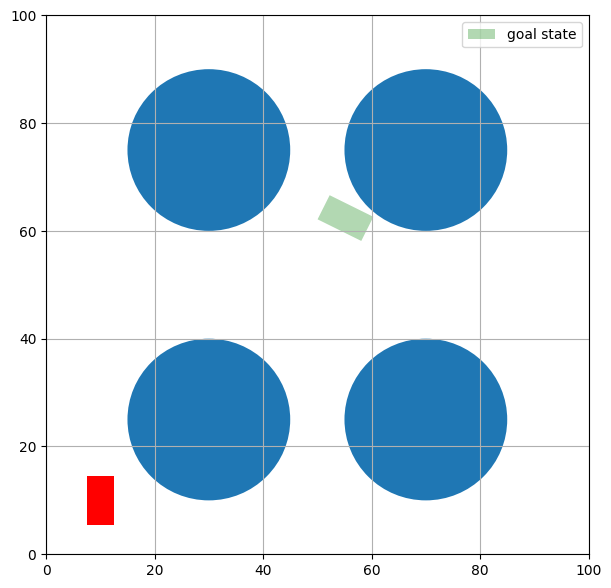

((array([82.36900006, 43.41398719]), 63.529411764705884), (array([87.36900006, 38.41398719]), 63.529411764705884))


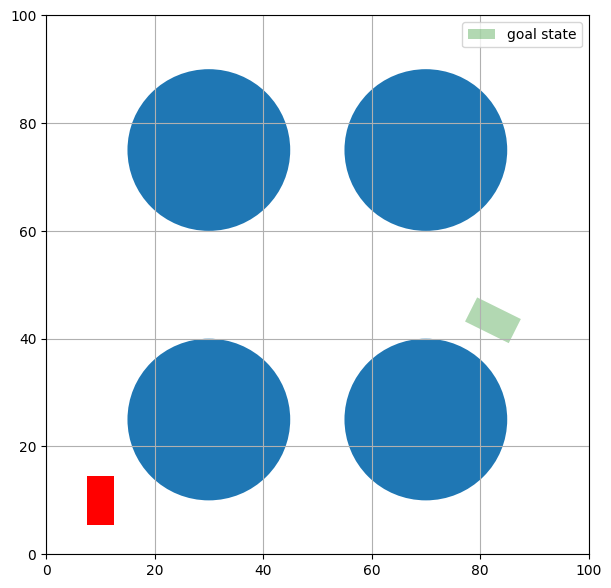

((array([85.30748137, 58.41398719]), 63.529411764705884), (array([90.30748137, 59.00516119]), 63.529411764705884))


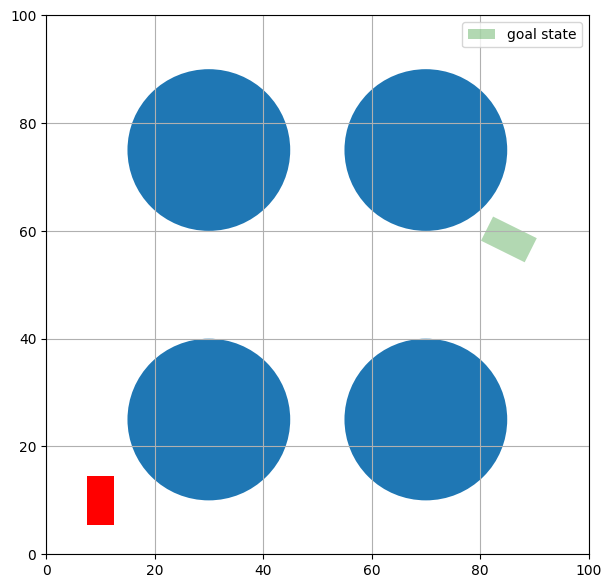

((array([90.30748137, 59.00516119]), 63.529411764705884), (array([94.35665731, 64.00516119]), 63.529411764705884))


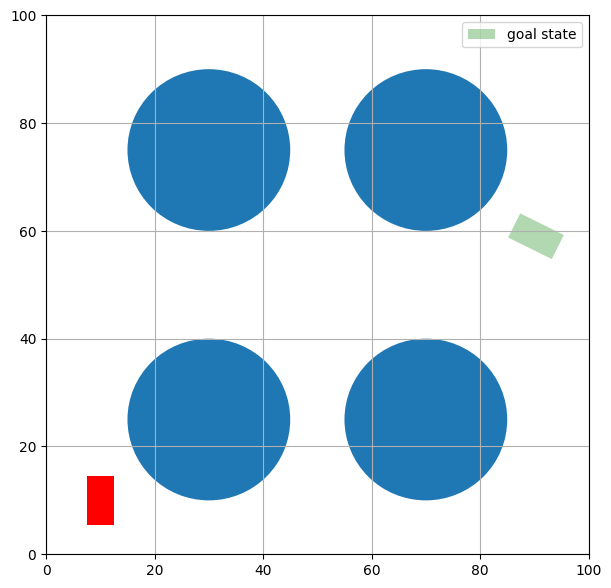

((array([ 8.25552826, 45.        ]), 0.0), (array([ 7.21896669, 46.78372581]), 0.0))


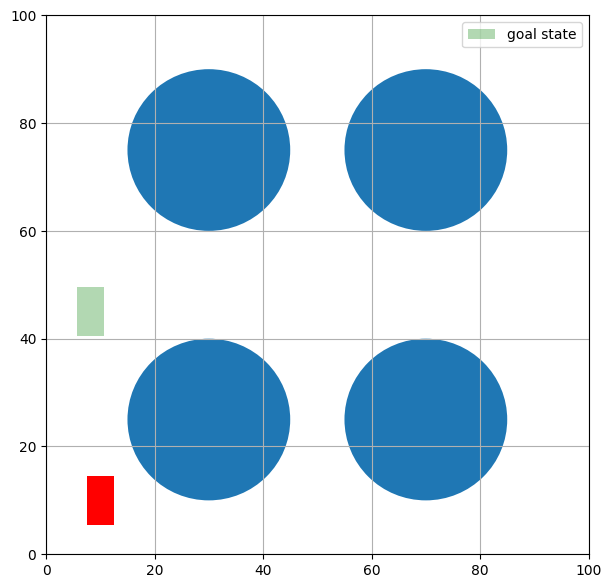

((array([45.18293453, 56.11333984]), 63.529411764705884), (array([43.179681  , 58.35981855]), 63.529411764705884))


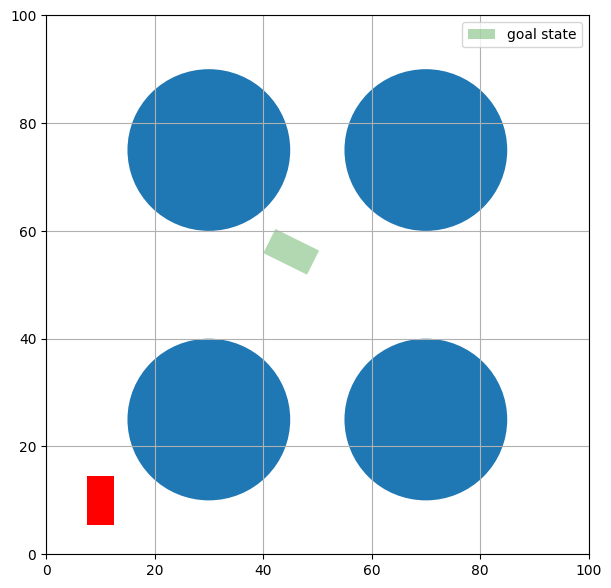

((array([51.52438723, 67.36705784]), 0.0), (array([52.07680214, 66.21967104]), 0.0))


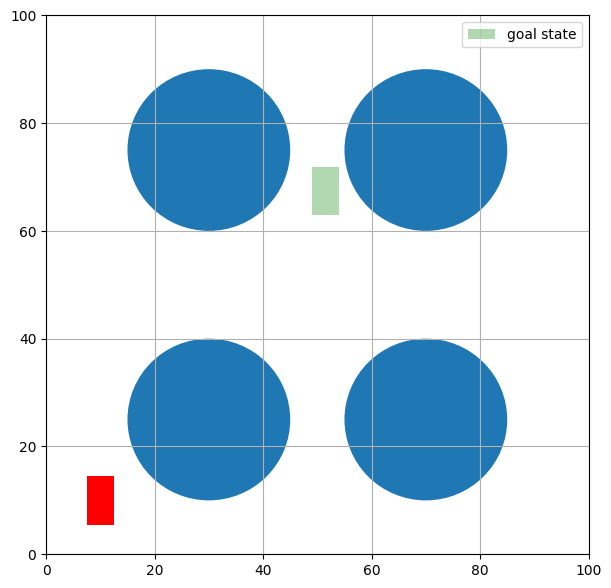

((array([47.36900006, 51.11333984]), 63.529411764705884), (array([48.68221272, 52.62210945]), 63.529411764705884))


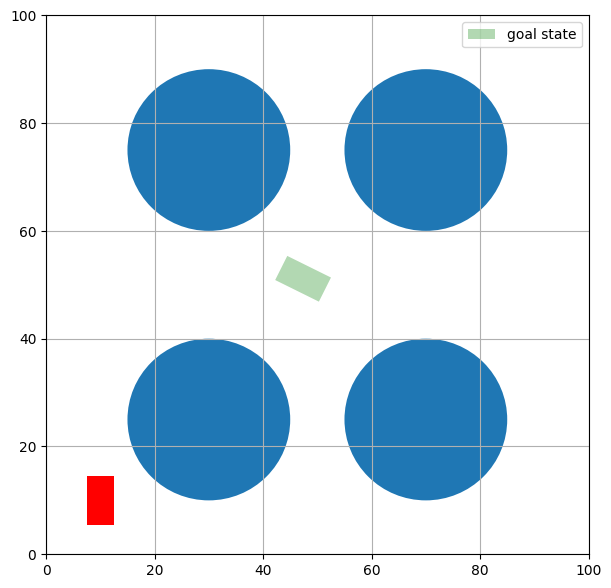

((array([69.41019434, 56.58251327]), 74.11764705882352), (array([67.29020522, 56.2217976 ]), 74.11764705882352))


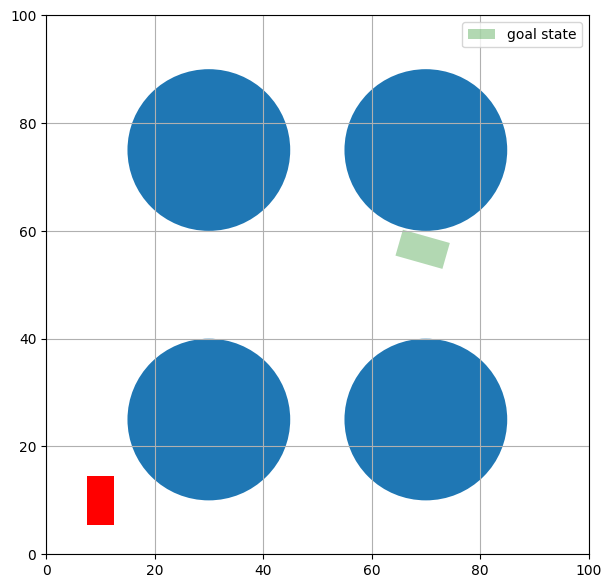

((array([66.61941793,  7.39327358]), 74.11764705882352), (array([71.61941793,  3.496122  ]), 74.11764705882352))


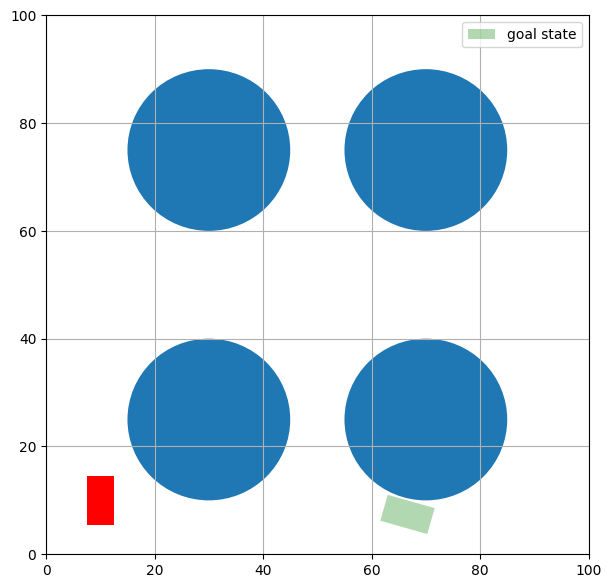

((array([48.57323652, 17.05220107]), 137.64705882352942), (array([49.3209629 , 13.80821907]), 137.64705882352942))


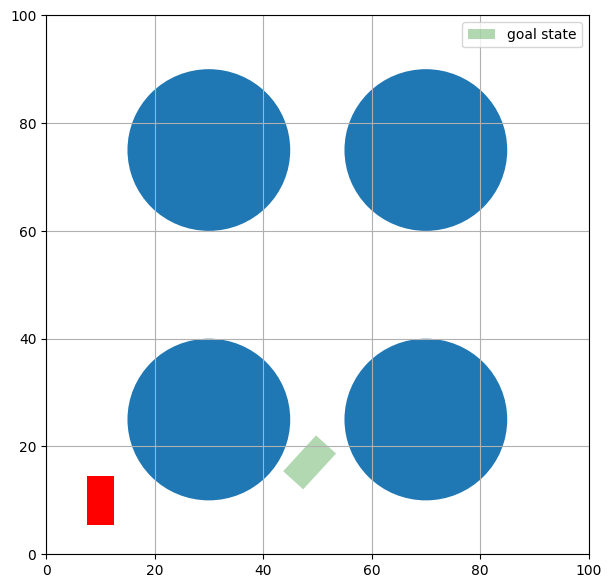

((array([47.67560567, 81.11333984]), 0.0), (array([52.67560567, 84.31217569]), 0.0))


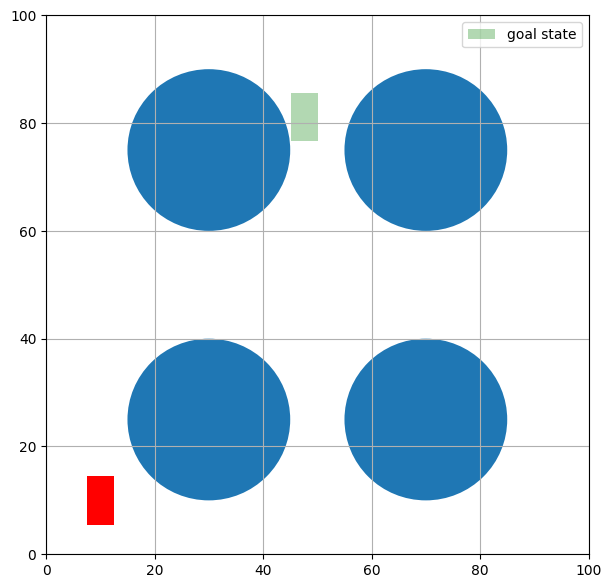

((array([22.36900006, 55.        ]), 0.0), (array([24.80833332, 56.56625594]), 52.94117647058823))


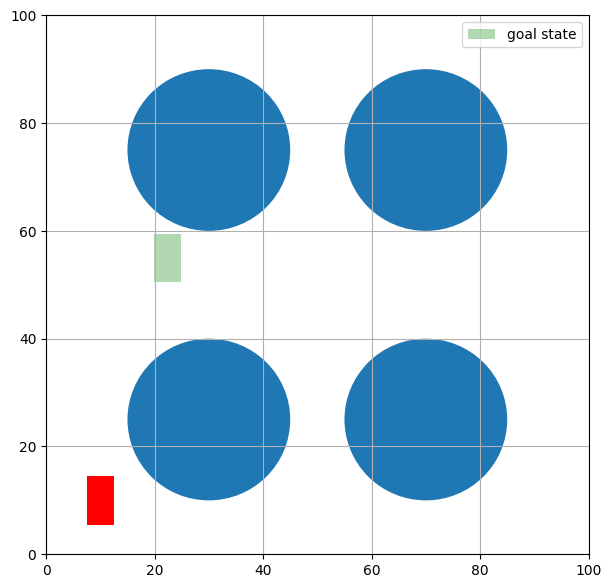

((array([13.76113848, 10.25107993]), 0.0), (array([15.11502881, 11.64376786]), 0.0))


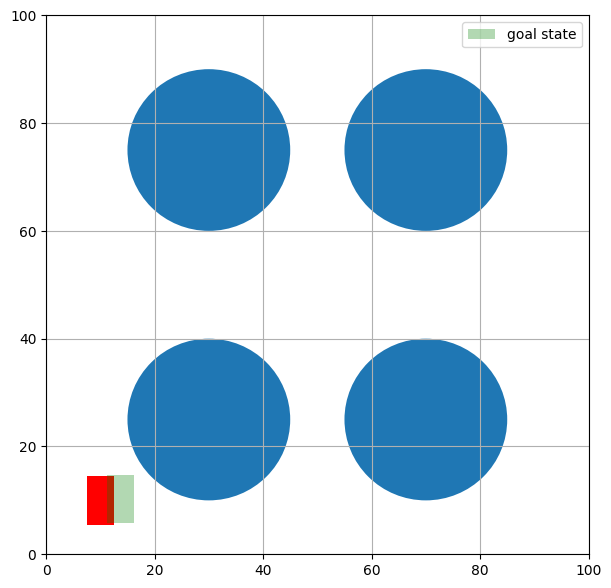

((array([43.179681  , 58.35981855]), 63.529411764705884), (array([42.47514368, 56.6900422 ]), 63.529411764705884))


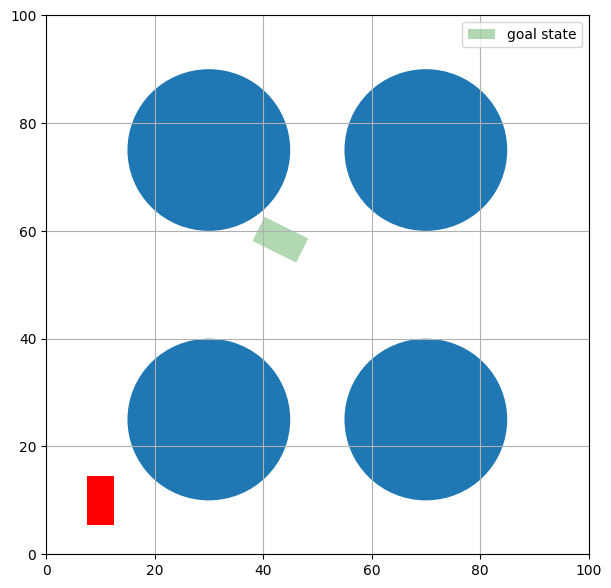

((array([14.72857098, 62.68444884]), 42.35294117647059), (array([16.63358038, 63.2904212 ]), 42.35294117647059))


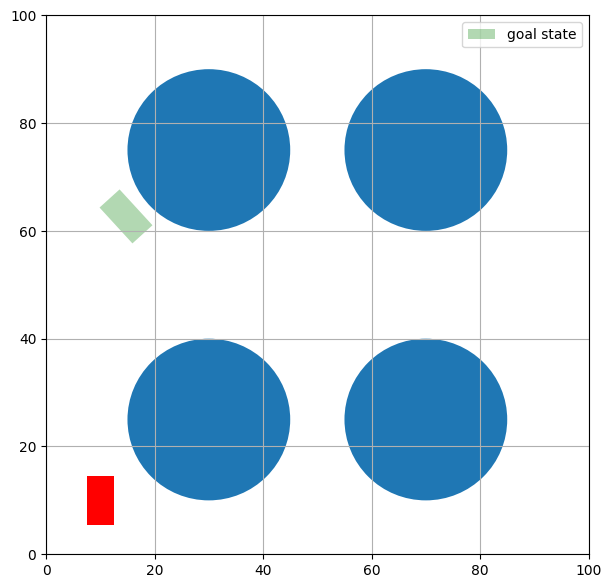

((array([ 3.31717416, 24.55013924]), 0.0), (array([ 2.10383456, 22.75388319]), 0.0))


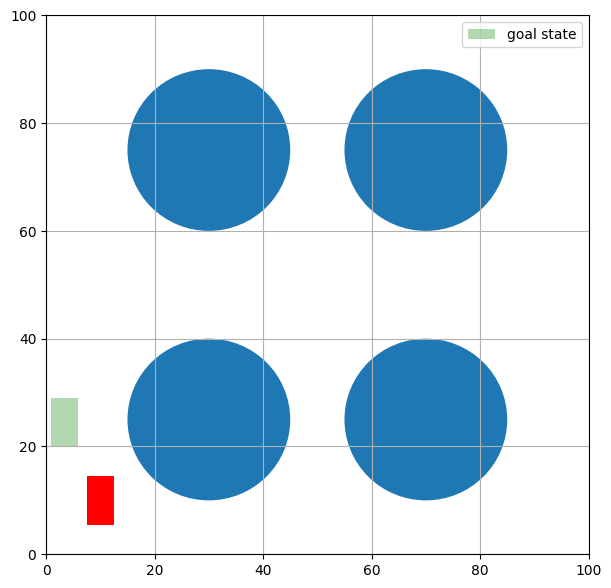

((array([71.61941793,  3.496122  ]), 74.11764705882352), (array([76.61941793,  7.54173569]), 95.29411764705883))


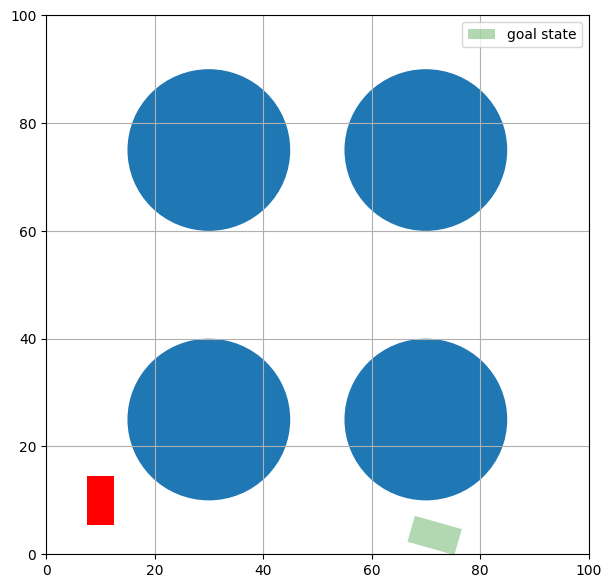

((array([85.30748137, 58.41398719]), 63.529411764705884), (array([82.94243099, 63.41398719]), 137.64705882352942))


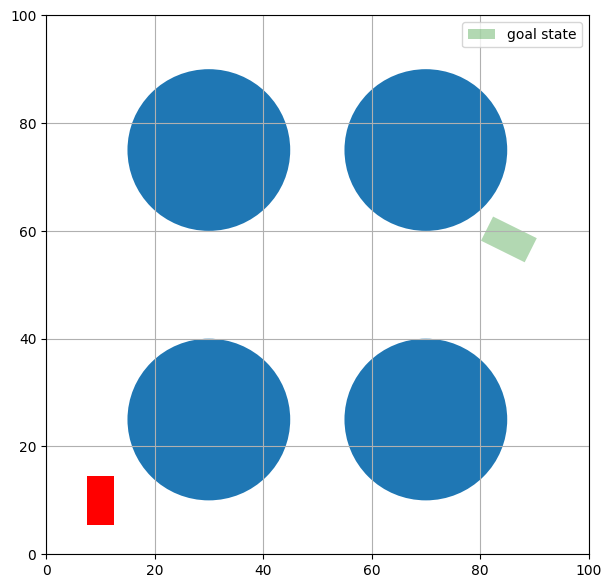

((array([32.36900006, 45.        ]), 0.0), (array([27.36900006, 42.50859809]), 95.29411764705883))


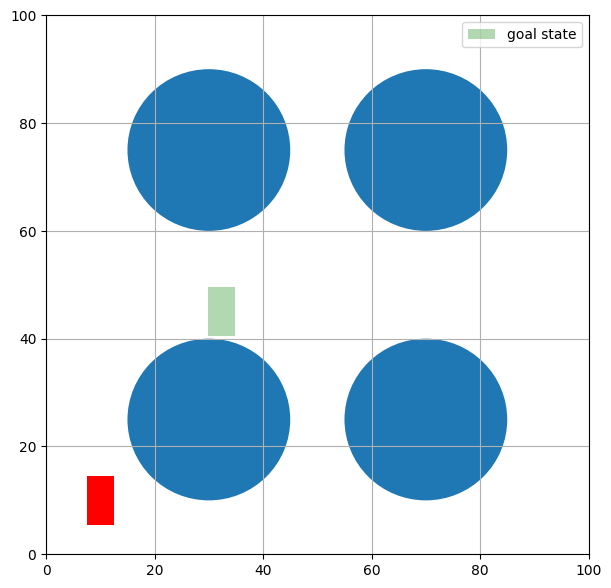

((array([67.29020522, 56.2217976 ]), 74.11764705882352), (array([64.93030742, 55.41684393]), 74.11764705882352))


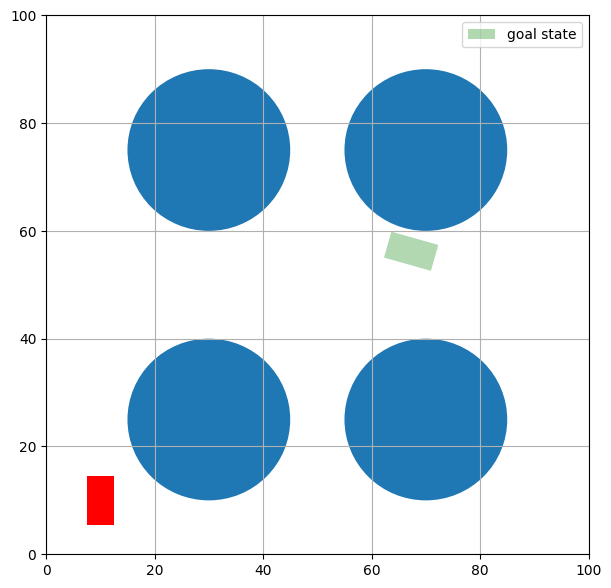

((array([69.41019434, 56.58251327]), 74.11764705882352), (array([68.79299988, 56.24022273]), 74.11764705882352))


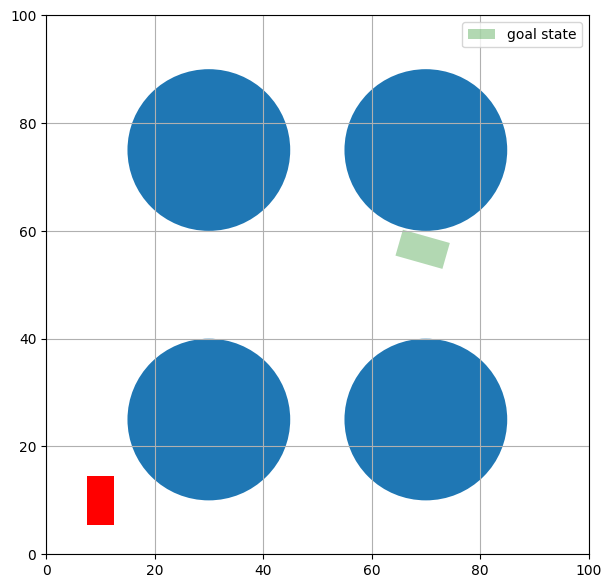

((array([69.41019434, 56.58251327]), 74.11764705882352), (array([68.79299988, 56.24022273]), 74.11764705882352))


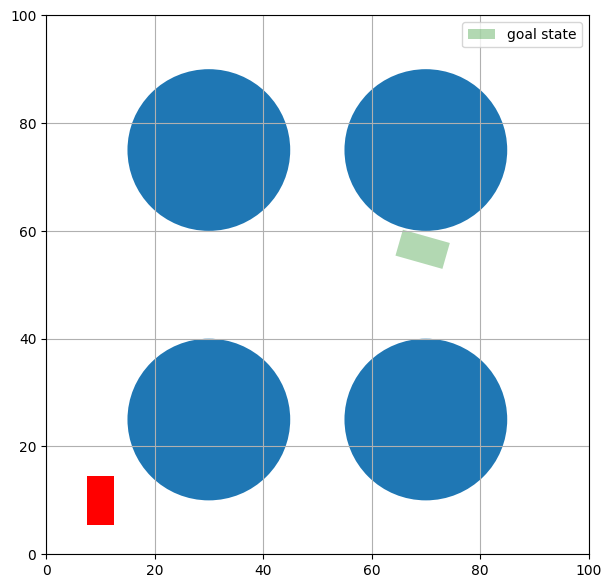

((array([76.61941793,  7.54173569]), 95.29411764705883), (array([81.61941793,  2.54173569]), 95.29411764705883))


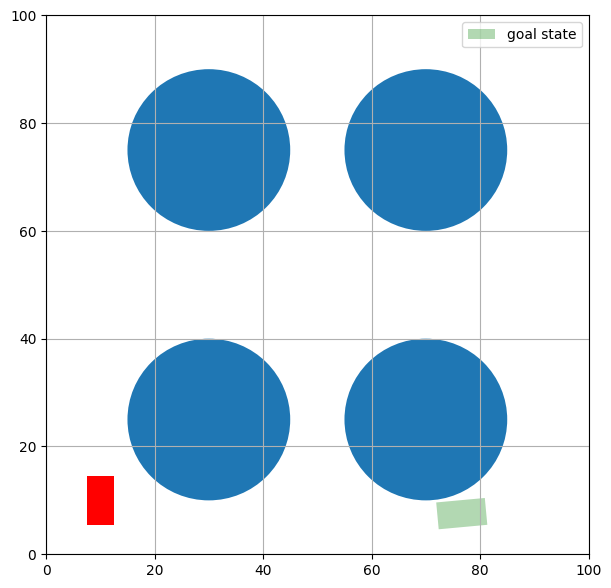

((array([41.67767421,  8.98125264]), 95.29411764705883), (array([45.90476528,  6.45099369]), 95.29411764705883))


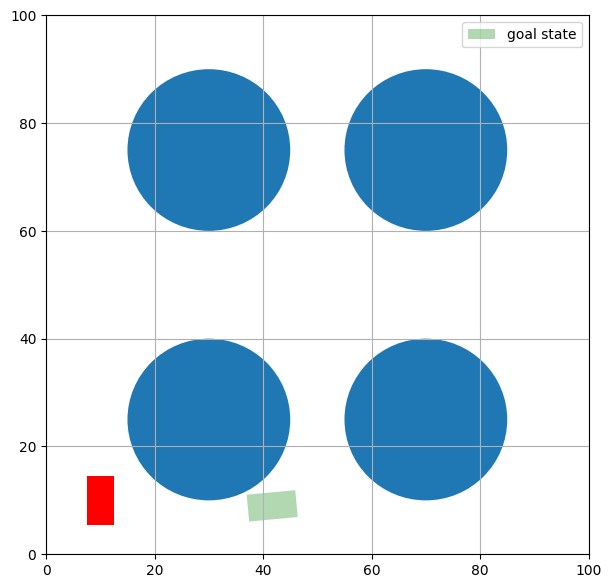

((array([76.61941793,  7.54173569]), 95.29411764705883), (array([75.60921728,  8.52530927]), 105.88235294117646))


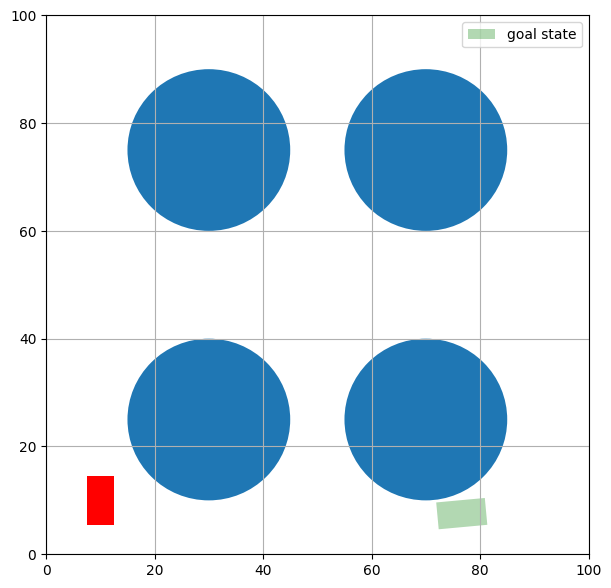

((array([90.30748137, 59.00516119]), 63.529411764705884), (array([95.30748137, 54.00516119]), 63.529411764705884))


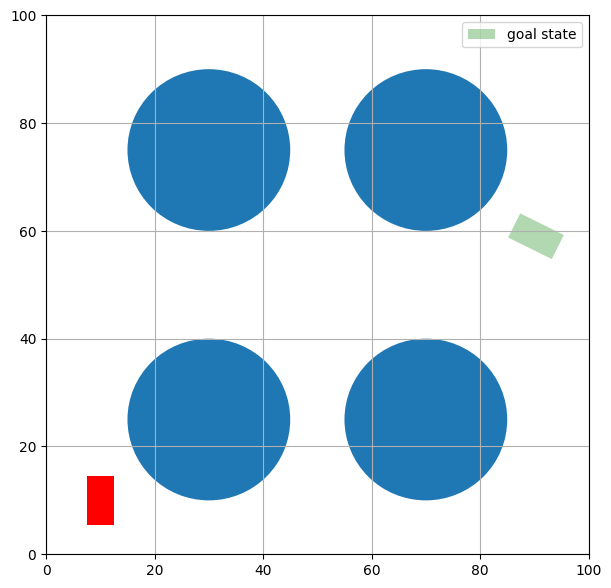

((array([94.35665731, 64.00516119]), 63.529411764705884), (array([89.96827122, 69.00516119]), 63.529411764705884))


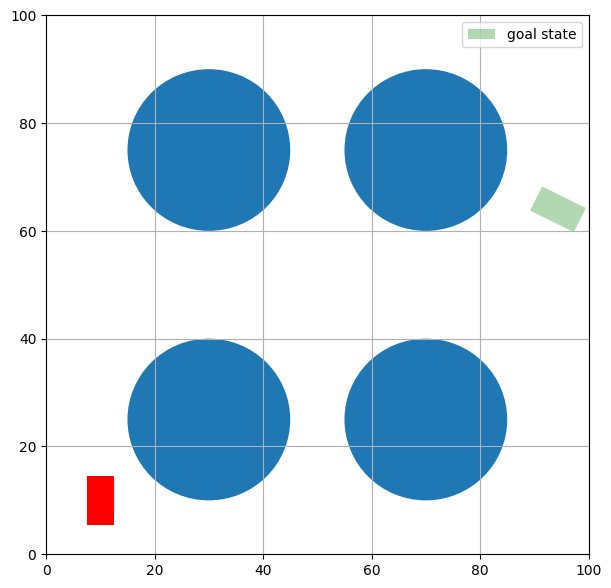

((array([11.69373181, 32.5446126 ]), 0.0), (array([11.52641362, 34.98728316]), 0.0))


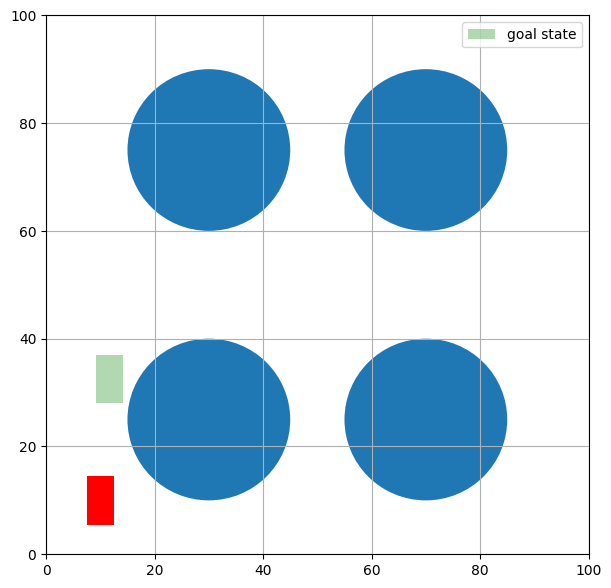

((array([52.67560567, 84.31217569]), 0.0), (array([49.64259469, 89.31217569]), 0.0))


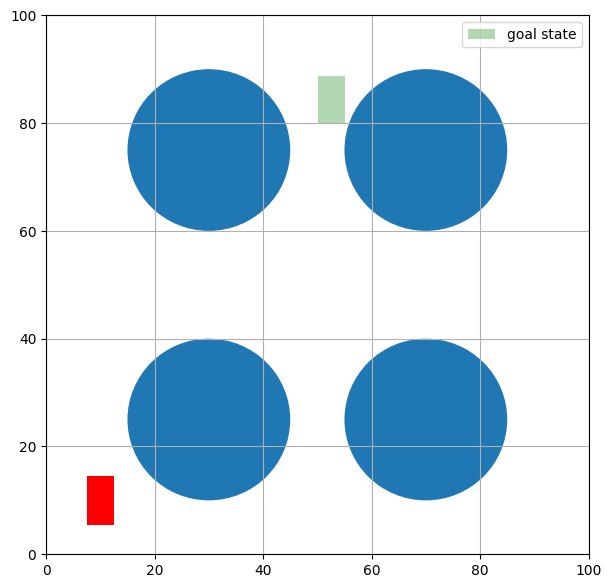

((array([32.36900006, 45.        ]), 0.0), (array([30.3209602 , 47.22853294]), 0.0))


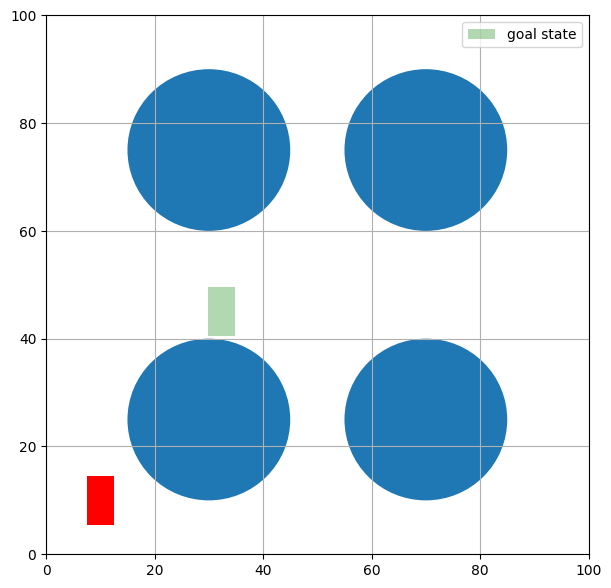

((array([67.36900006, 51.11333984]), 63.529411764705884), (array([63.93918791, 52.14704577]), 63.529411764705884))


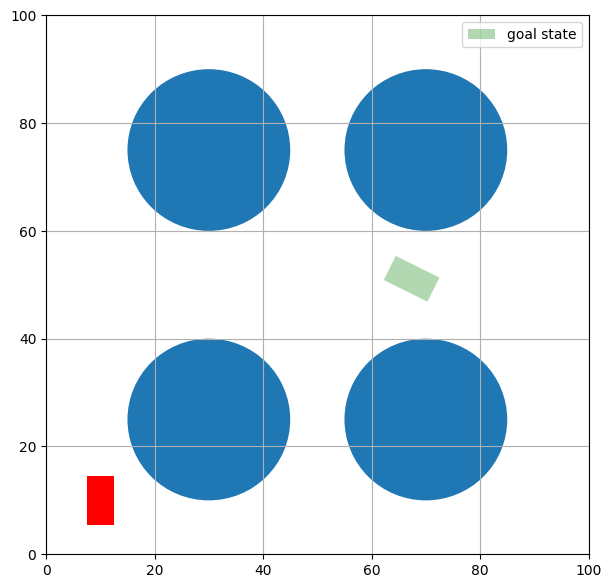

((array([11.83783706, 30.        ]), 0.0), (array([12.03818317, 28.96613323]), 0.0))


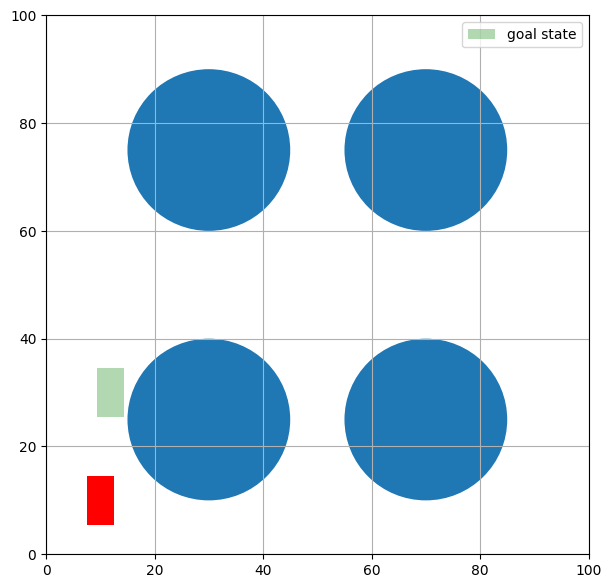

((array([52.36900006, 36.11333984]), 63.529411764705884), (array([50.40430402, 38.29787096]), 63.529411764705884))


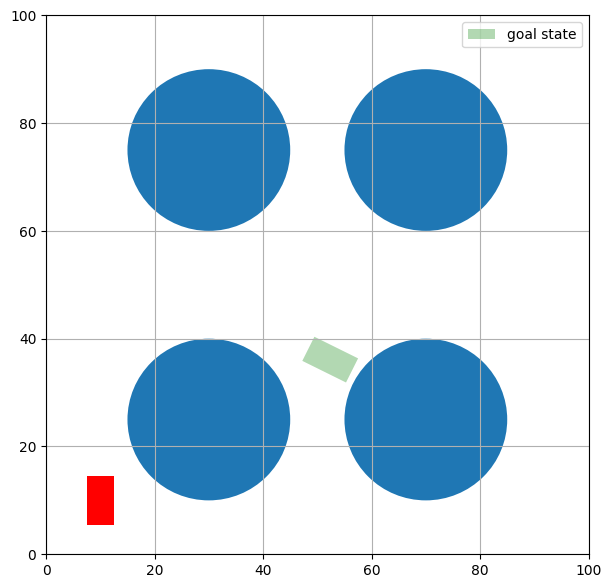

((array([95.30748137, 54.00516119]), 63.529411764705884), (array([99.66081655, 49.88460719]), 63.529411764705884))


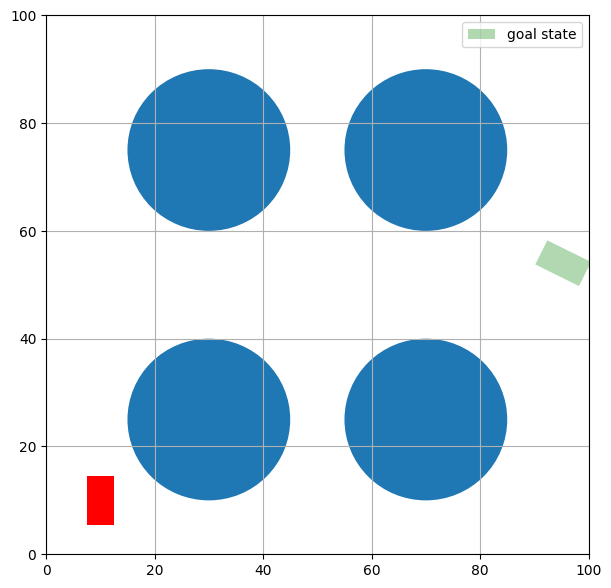

((array([ 0.85576686, 67.52785522]), 42.35294117647059), (array([ 0.8673487 , 64.62105533]), 42.35294117647059))


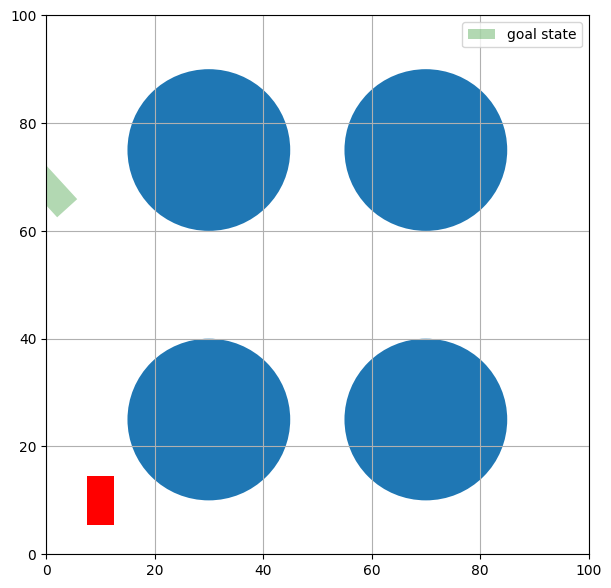

((array([55.18293453, 62.37499512]), 63.529411764705884), (array([55.43995819, 57.37499512]), 63.529411764705884))


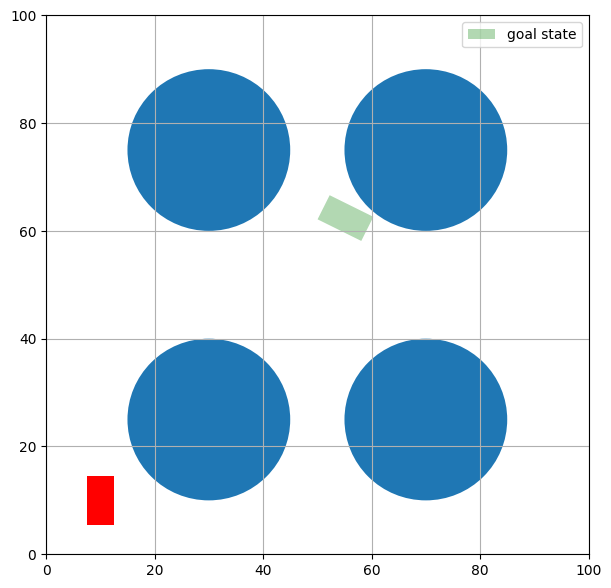

((array([36.67767421,  7.61999492]), 95.29411764705883), (array([34.30854456,  6.3601973 ]), 95.29411764705883))


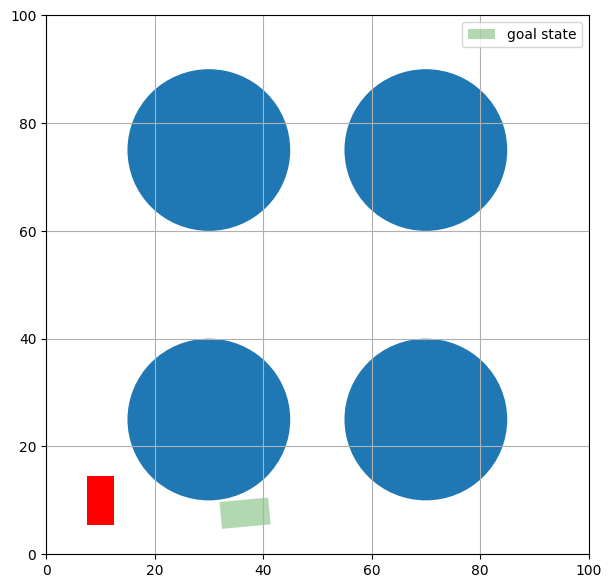

((array([49.64259469, 89.31217569]), 0.0), (array([54.64259469, 92.68008682]), 0.0))


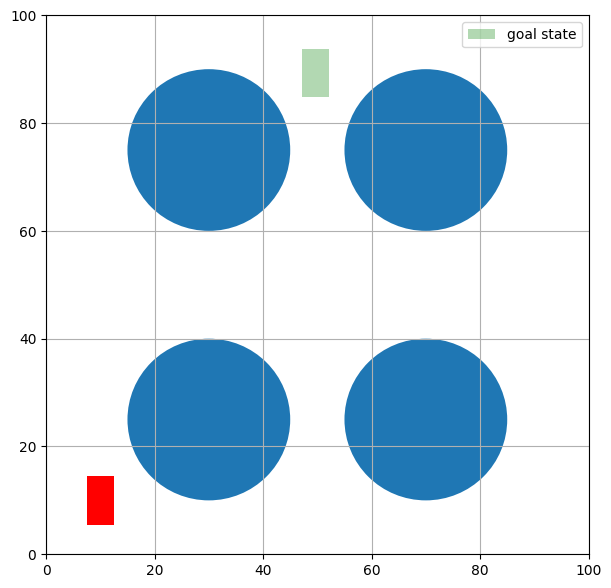

((array([ 8.56968824, 74.65057631]), 42.35294117647059), (array([12.20363275, 79.65057631]), 0.0))


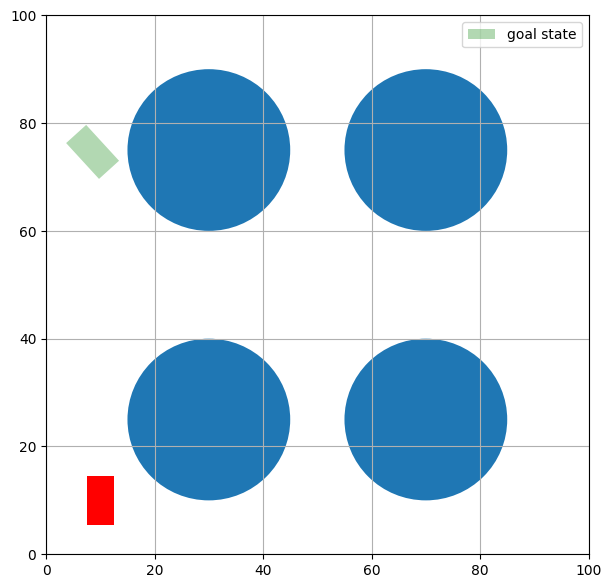

((array([ 3.56968824, 69.65057631]), 42.35294117647059), (array([ 3.01436709, 72.58523763]), 42.35294117647059))


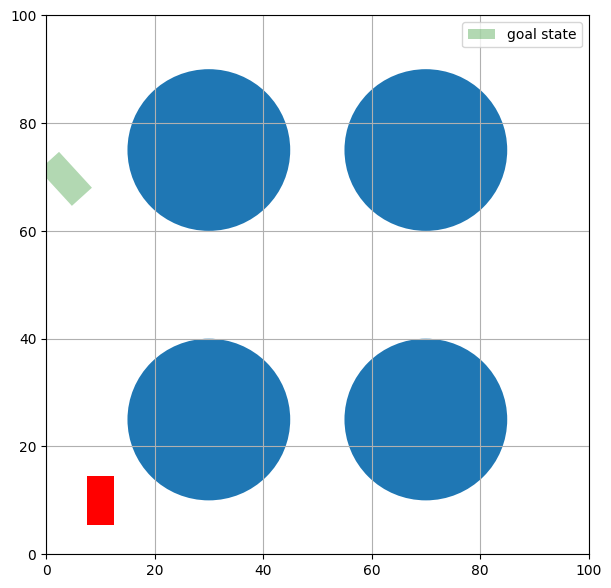

((array([10.17854581, 15.        ]), 0.0), (array([ 9.59815054, 15.26549438]), 0.0))


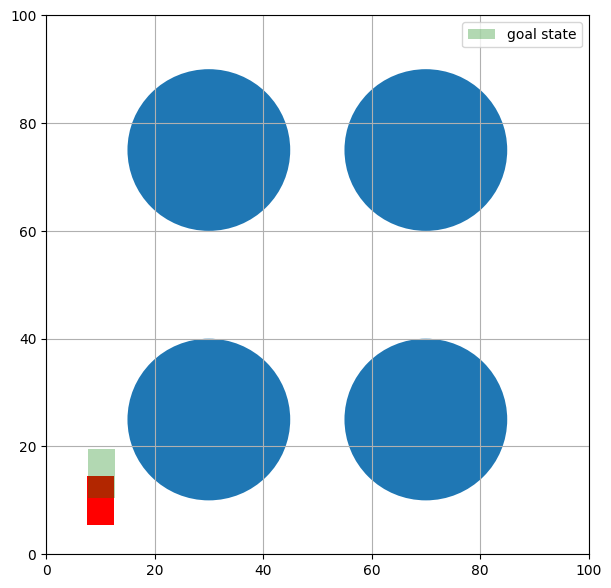

((array([10.17854581, 15.        ]), 0.0), (array([ 9.59815054, 15.26549438]), 0.0))


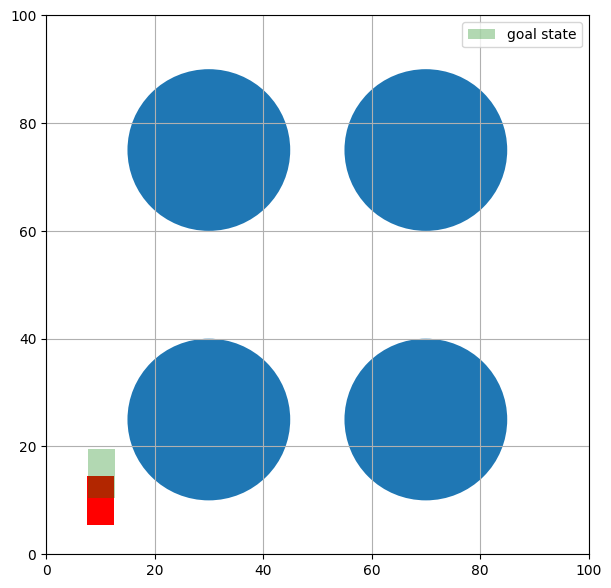

((array([ 1.83783706, 33.83409712]), 0.0), (array([ 0.97626893, 38.83409712]), 0.0))


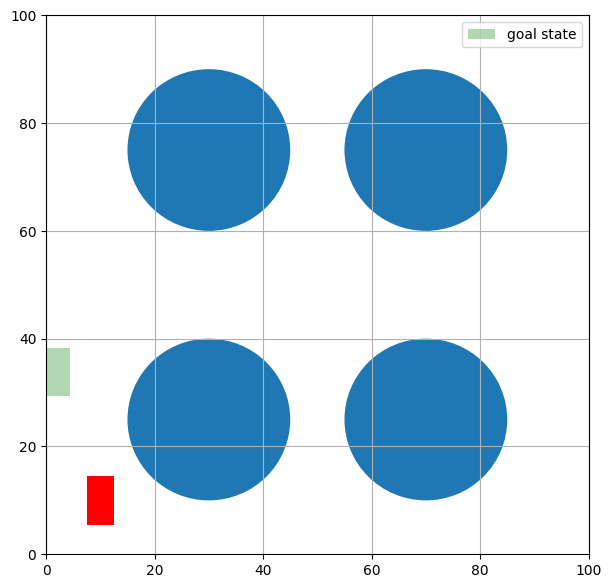

((array([27.36900006, 42.50859809]), 95.29411764705883), (array([27.27242335, 43.7200665 ]), 95.29411764705883))


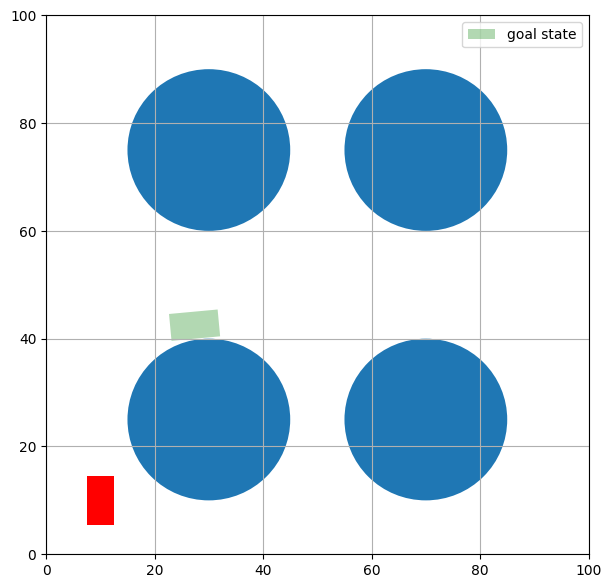

((array([57.36900006, 41.11333984]), 63.529411764705884), (array([56.19335282, 40.43943289]), 63.529411764705884))


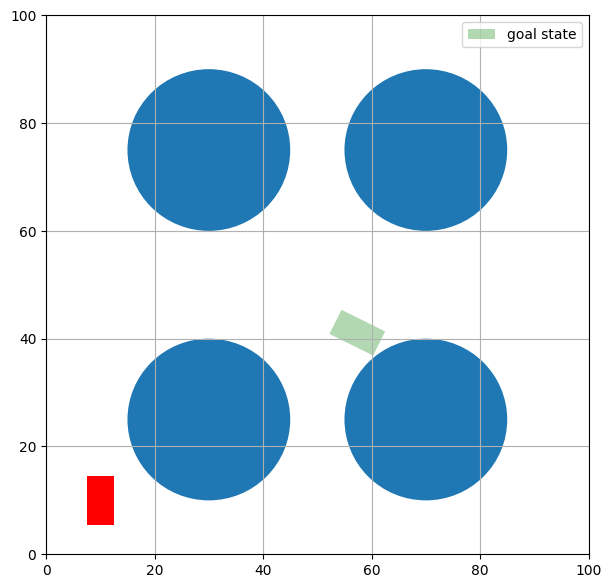

((array([12.03818317, 28.96613323]), 0.0), (array([ 8.45200103, 27.83099833]), 0.0))


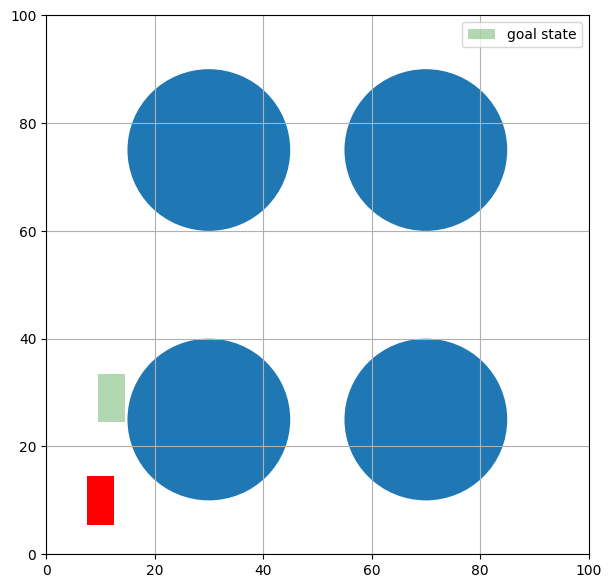

((array([49.89602345, 71.11333984]), 148.23529411764704), (array([47.46048855, 70.81605393]), 158.8235294117647))


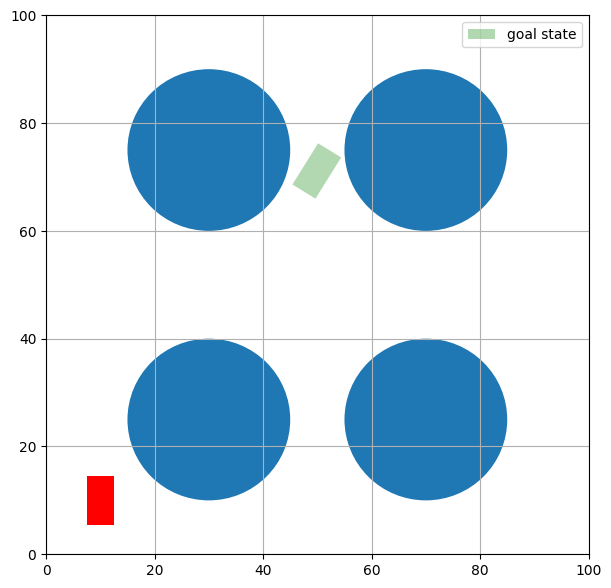

((array([81.61941793,  2.54173569]), 95.29411764705883), (array([85.03192277,  6.3798554 ]), 95.29411764705883))


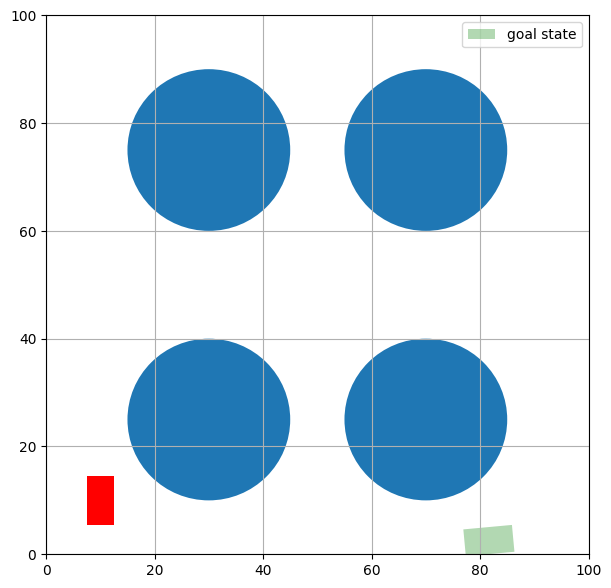

((array([85.03192277,  6.3798554 ]), 95.29411764705883), (array([90.03192277, 11.3798554 ]), 95.29411764705883))


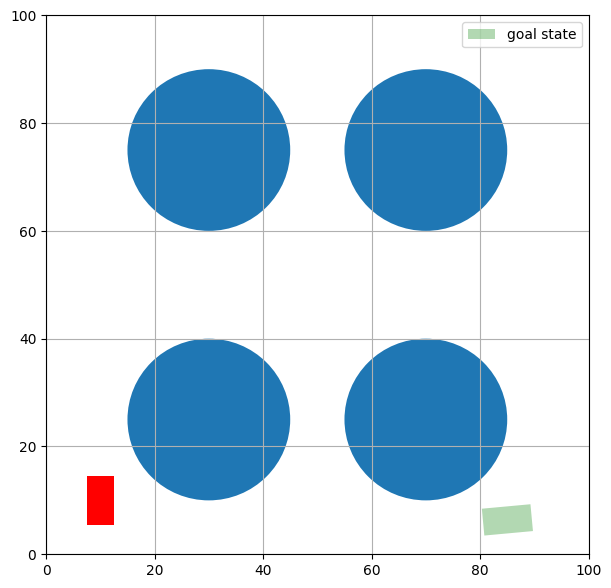

((array([89.96827122, 69.00516119]), 63.529411764705884), (array([94.44690053, 74.00516119]), 63.529411764705884))


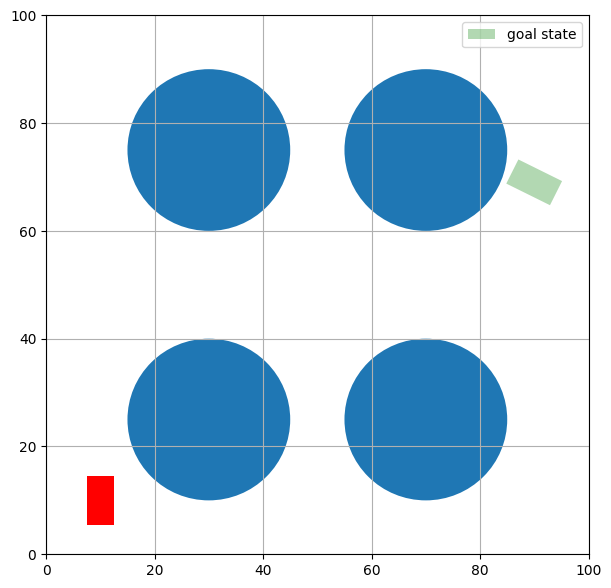

((array([30.60213931,  4.84956357]), 42.35294117647059), (array([31.54044396,  4.65652096]), 42.35294117647059))


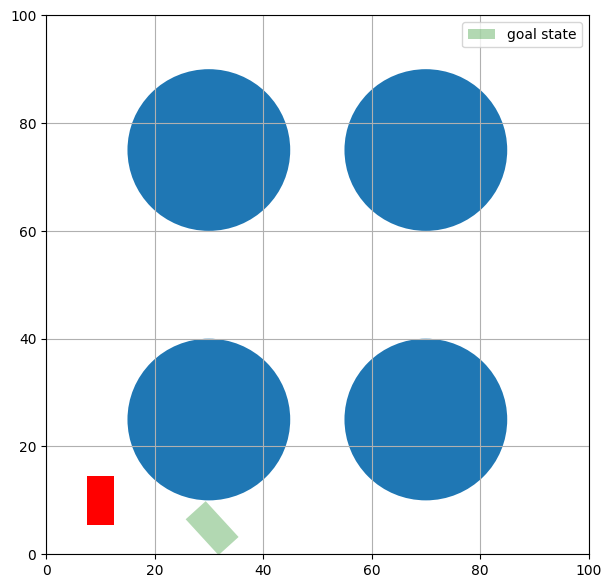

((array([30.60213931,  4.84956357]), 42.35294117647059), (array([31.54044396,  4.65652096]), 42.35294117647059))


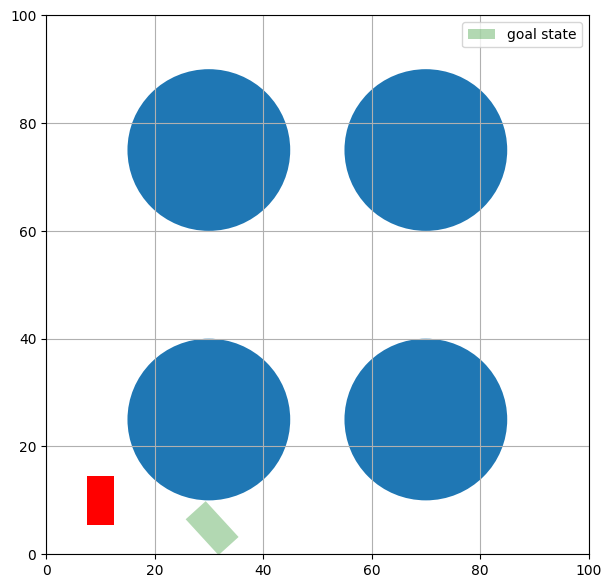

((array([72.36900006, 46.11333984]), 63.529411764705884), (array([72.42664483, 43.98660428]), 63.529411764705884))


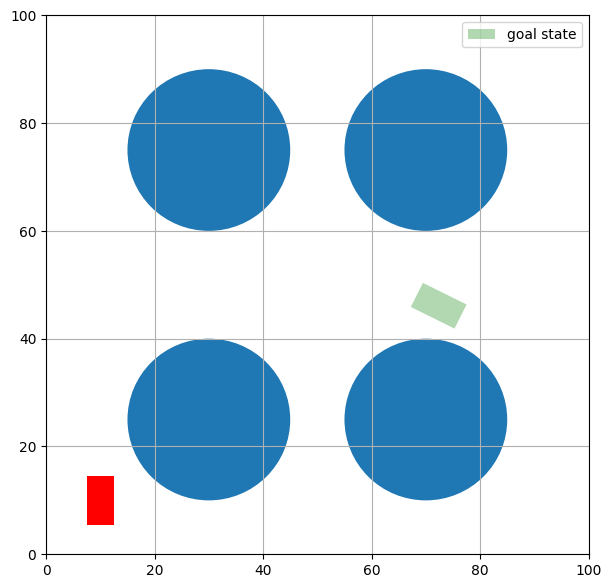

((array([49.64259469, 89.31217569]), 0.0), (array([44.64259469, 94.31217569]), 0.0))


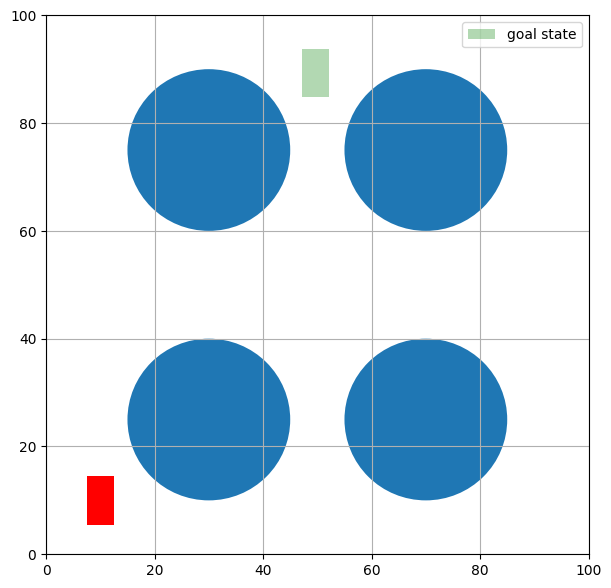

((array([32.36900006, 55.        ]), 0.0), (array([37.25706804, 56.42904203]), 10.588235294117647))


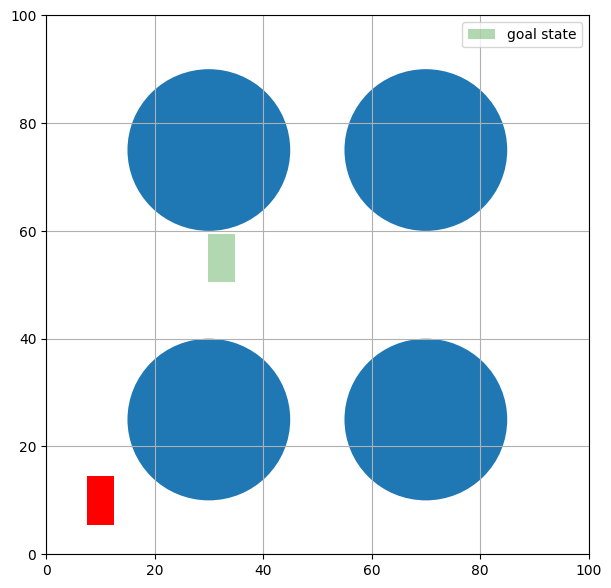

((array([48.57323652, 17.05220107]), 137.64705882352942), (array([50.33274058, 17.02176836]), 137.64705882352942))


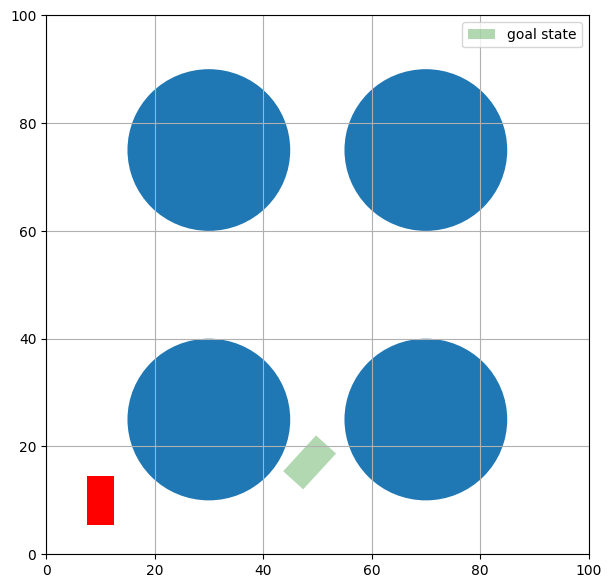

((array([56.19335282, 40.43943289]), 63.529411764705884), (array([55.09220181, 40.74354895]), 63.529411764705884))


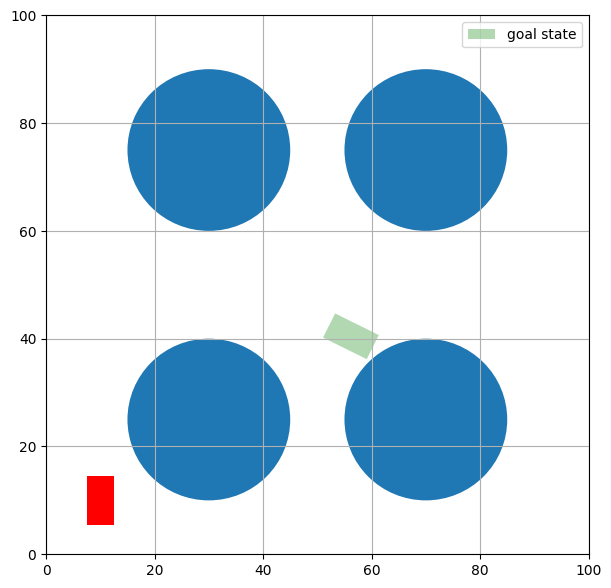

((array([54.64259469, 92.68008682]), 0.0), (array([59.64259469, 88.44773338]), 127.05882352941177))


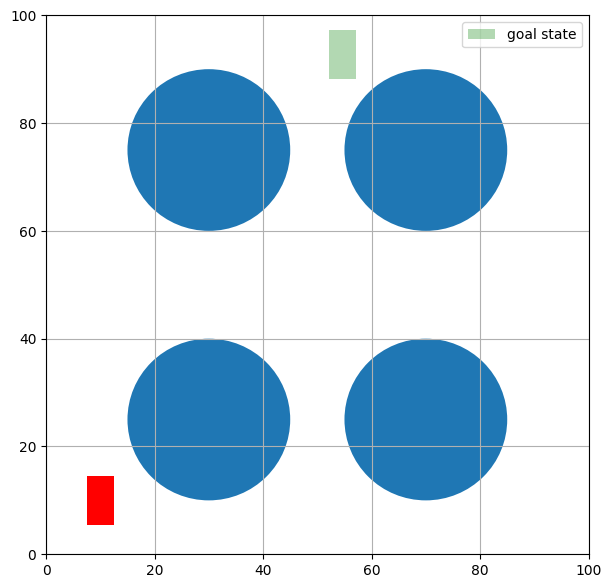

((array([44.64259469, 94.31217569]), 0.0), (array([39.64259469, 90.94390739]), 42.35294117647059))


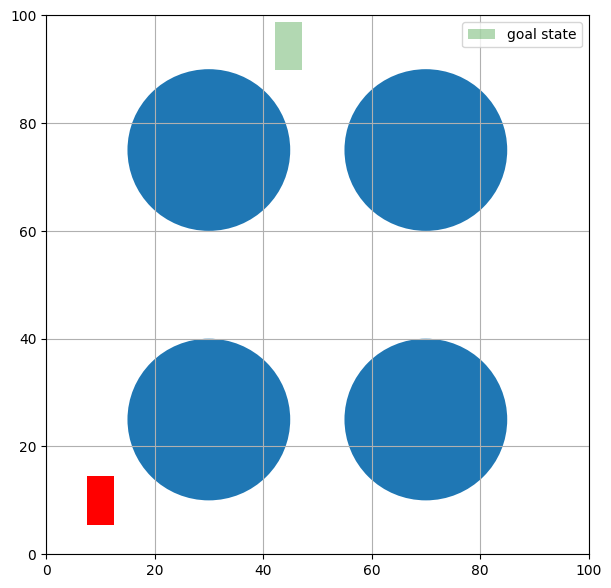

((array([12.20363275, 79.65057631]), 0.0), (array([15.47884705, 84.65057631]), 148.23529411764704))


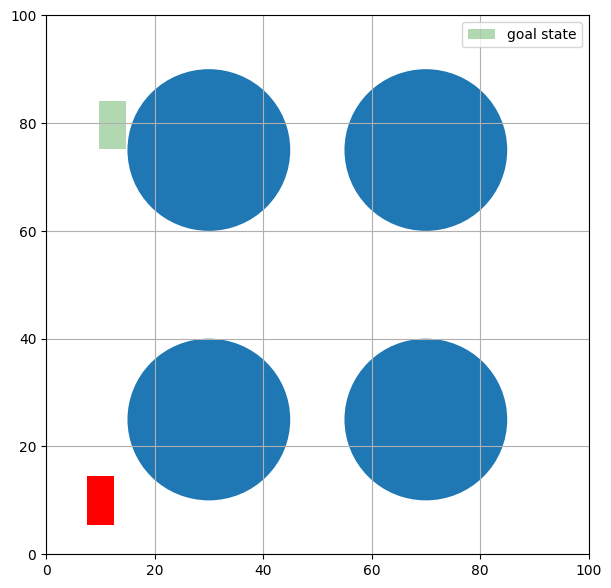

((array([87.36900006, 38.41398719]), 63.529411764705884), (array([92.36900006, 33.41398719]), 63.529411764705884))


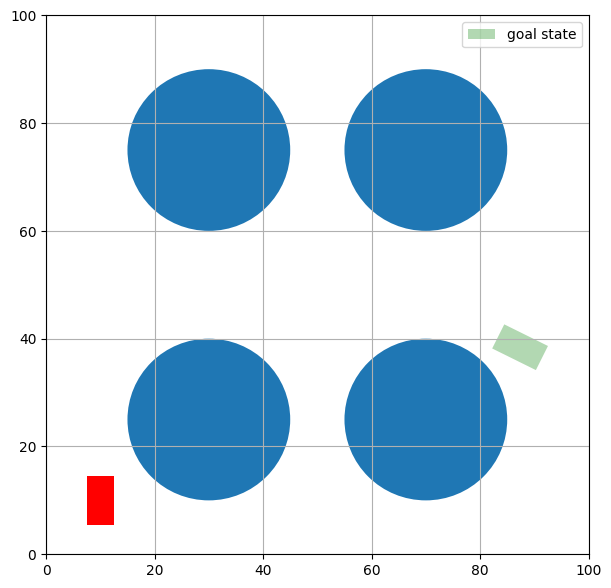

((array([45.90476528,  6.45099369]), 95.29411764705883), (array([49.02176984,  3.65212899]), 95.29411764705883))


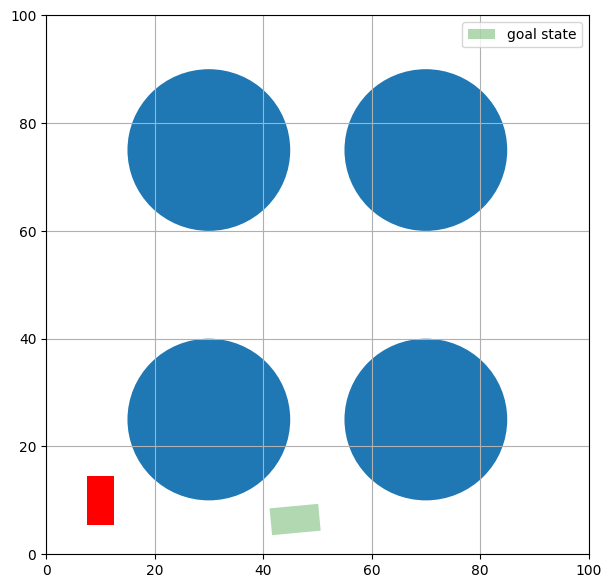

((array([94.44690053, 74.00516119]), 63.529411764705884), (array([98.65981029, 79.00516119]), 63.529411764705884))


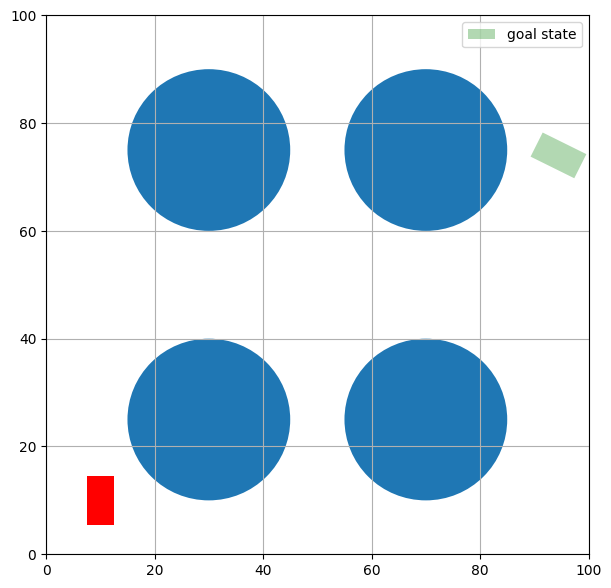

((array([94.44690053, 74.00516119]), 63.529411764705884), (array([89.44690053, 79.00516119]), 0.0))


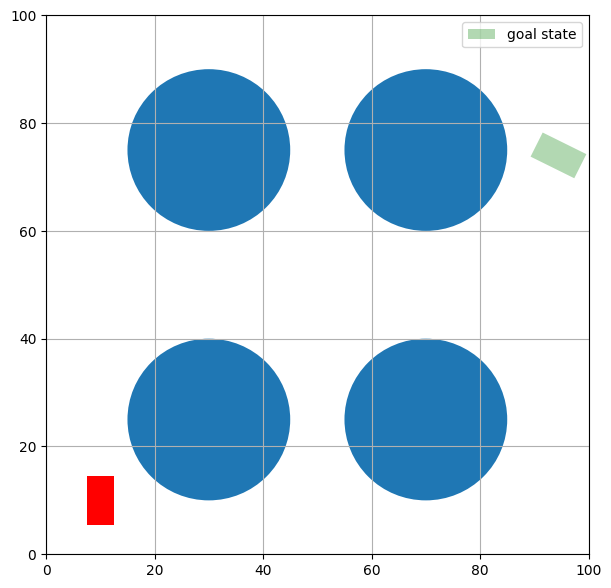

((array([89.44690053, 79.00516119]), 0.0), (array([94.44690053, 84.00516119]), 0.0))


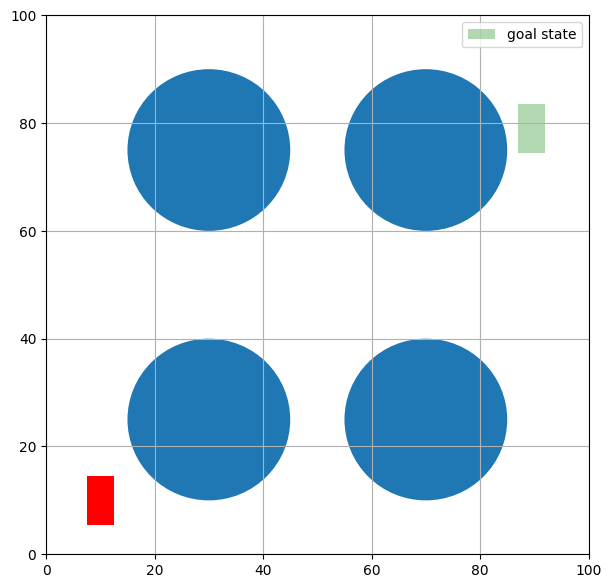

((array([37.36900006, 41.11333984]), 63.529411764705884), (array([42.36900006, 37.52477021]), 42.35294117647059))


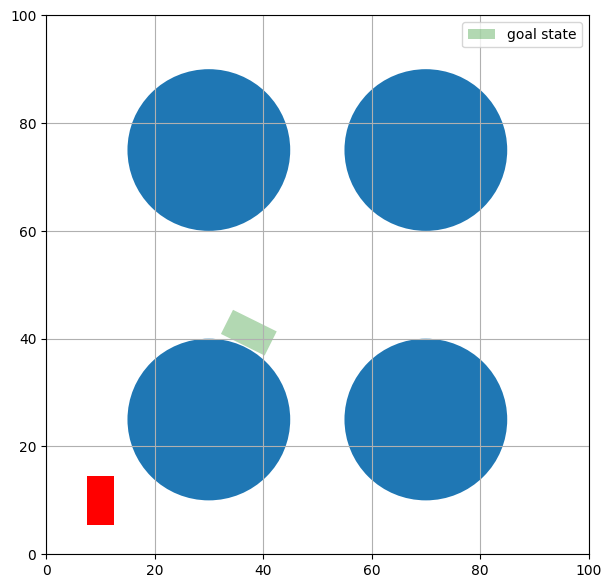

((array([89.44690053, 89.00516119]), 0.0), (array([90, 90]), -1.5707963267948966))


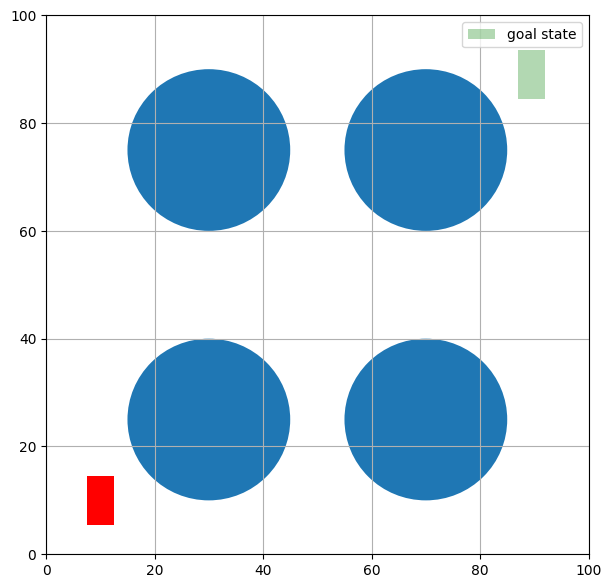

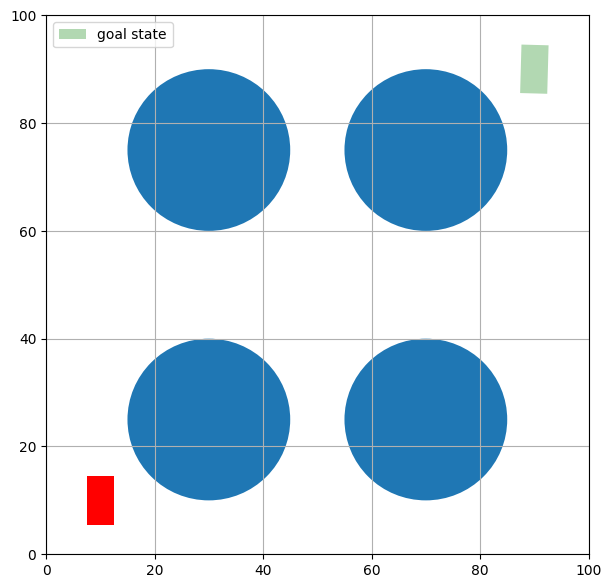

In [118]:
#s = []
for i in E:
    #s.append(i[0])
    print(i)
    env.render(goal_state=State(*i[0]))
env.render(goal_state=State(*E[-1][1]))

In [14]:
ls = [True, True, True]
all(val == True for val in ls)

True

In [11]:
env = Environment.from_config(X_init, SIMPLE_CONFIG)

[array([10, 10]), 0]

In [17]:
State.generate_lin_space(X_init[0], X_goal[0], 10)

[array([10, 10]),
 array([18., 18.]),
 array([26., 26.]),
 array([34., 34.]),
 array([42., 42.]),
 array([50., 50.]),
 array([58., 58.]),
 array([66., 66.]),
 array([74., 74.]),
 array([82., 82.]),
 array([90., 90.])]

In [14]:
State(X_init[0], X_init[1])

In [ ]:
log(card (V ))